In [ ]:
!git clone https://github.com/zhn66776/Tidal_try.git

Cloning into 'Tidal_try'...
remote: Enumerating objects: 610, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 610 (delta 137), reused 218 (delta 118), pack-reused 355 (from 1)
Receiving objects: 100% (610/610), 71.26 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (268/268), done.


In [ ]:
cd Tidal_try/

/content/Tidal_try


total length：175296
train set: 11000, test set: 1000
trainX: (10970, 30, 2), trainY: (10970,)
testX: (970, 30, 2), testY: (970,)
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1162 - val_loss: 0.0646 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0556 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0137 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0073 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0051 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0045 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - val_loss: 0.0017 - learning_rate

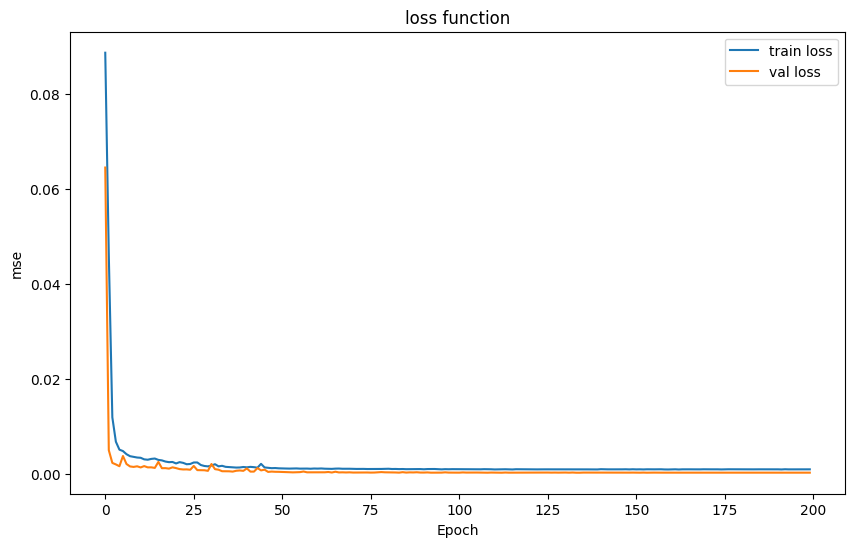

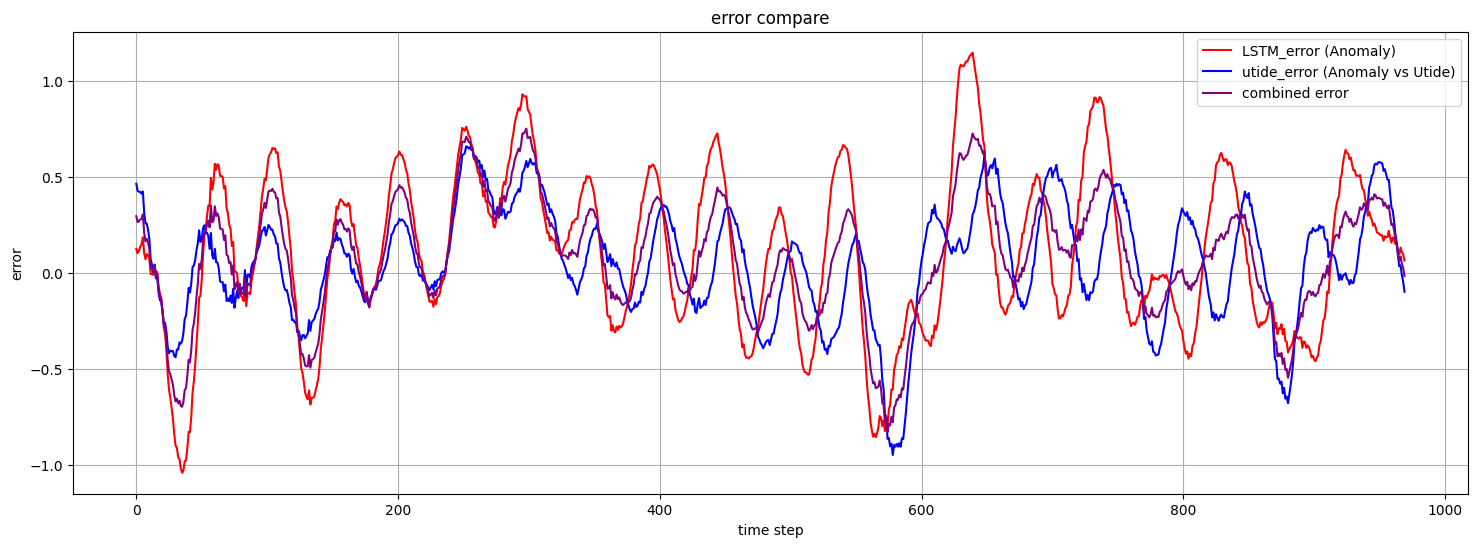

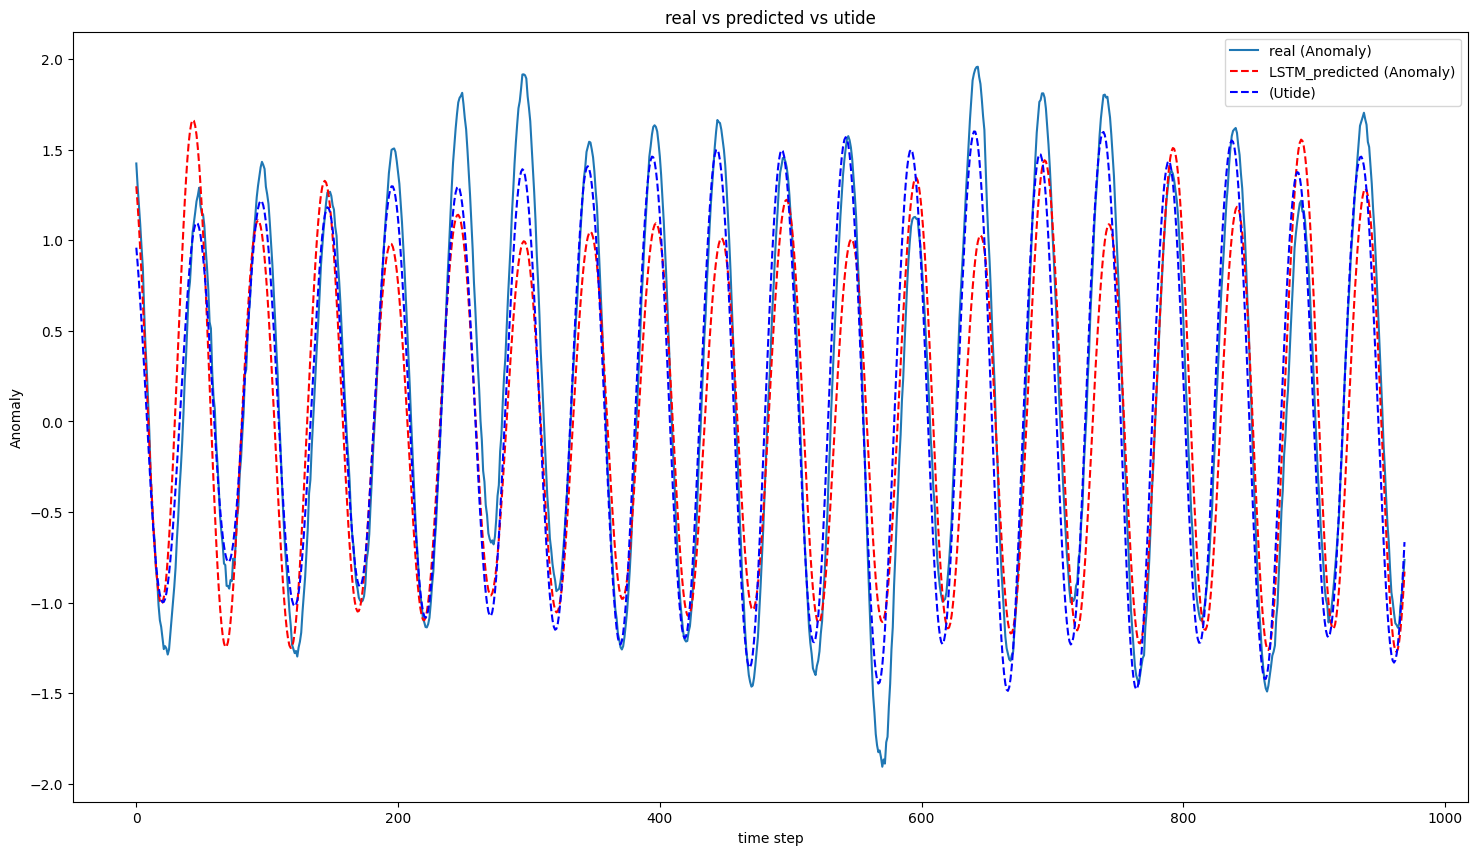

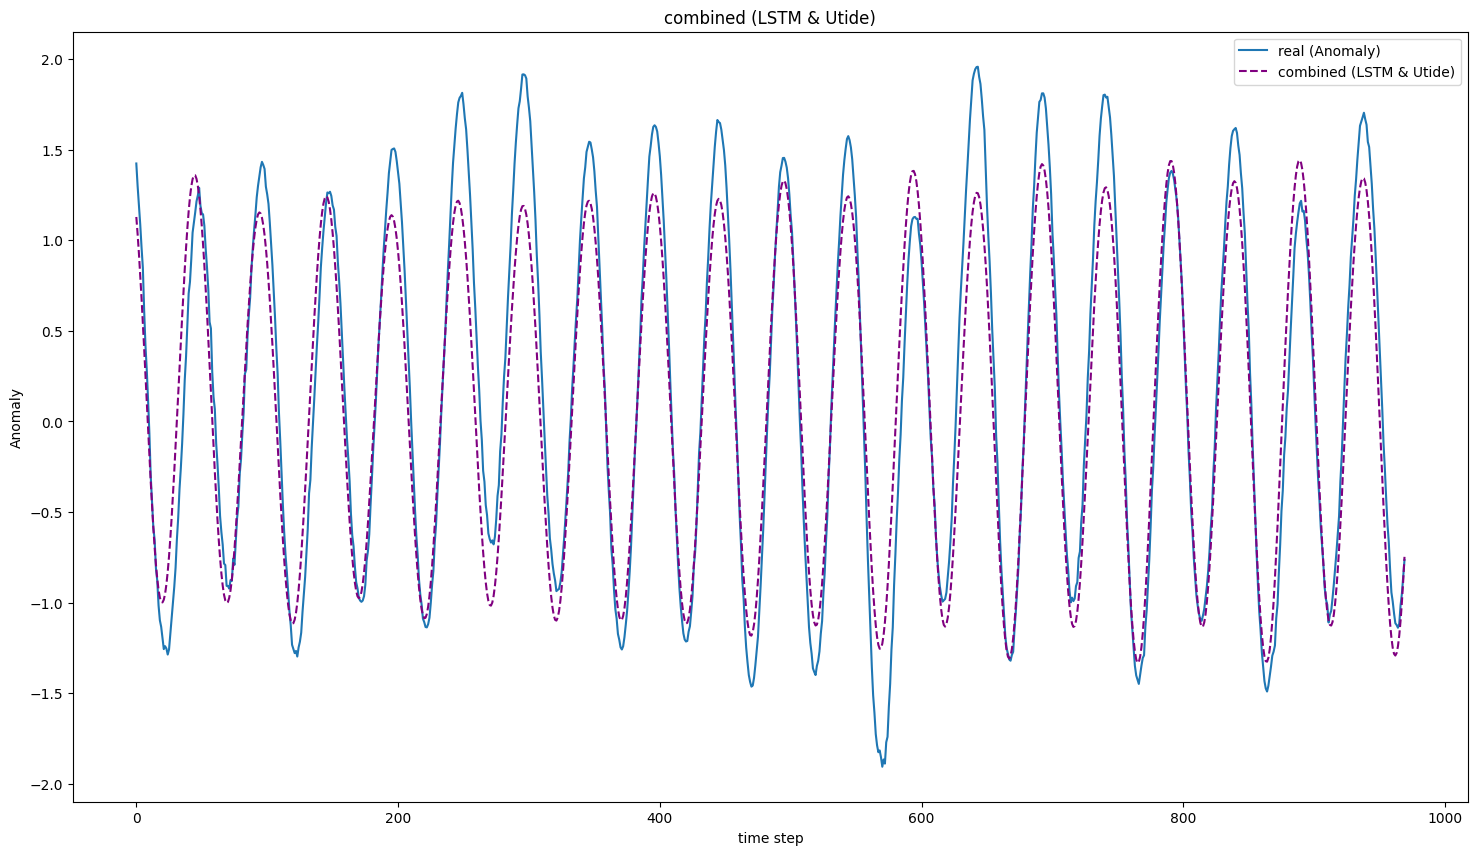

LSTM eva：
Test RMSE: 0.43
Test MAE: 0.36
Test R²: 0.81

eva：
Harmonic RMSE: 0.30
Harmonic MAE: 0.24
Harmonic R²: 0.91

weighted combined：
Combined RMSE: 0.31
Combined MAE: 0.25
Combined R²: 0.90


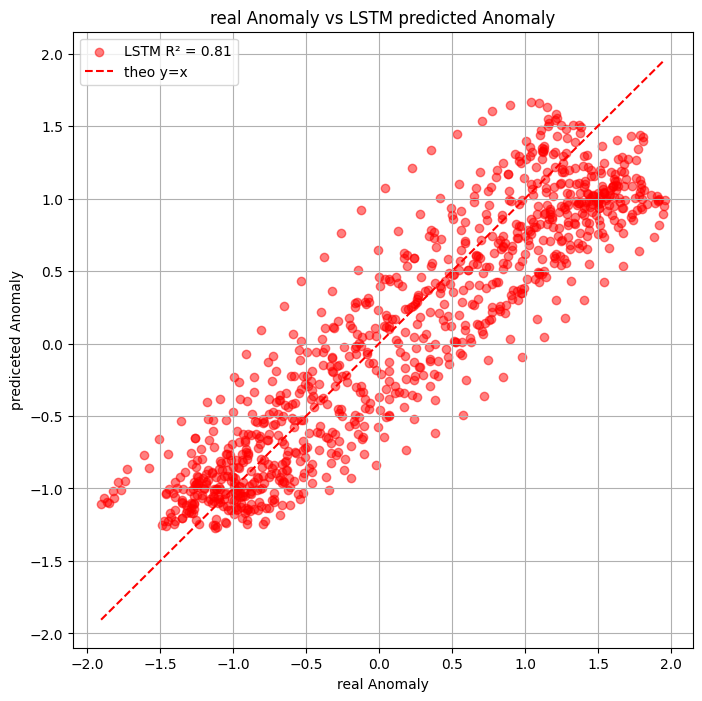

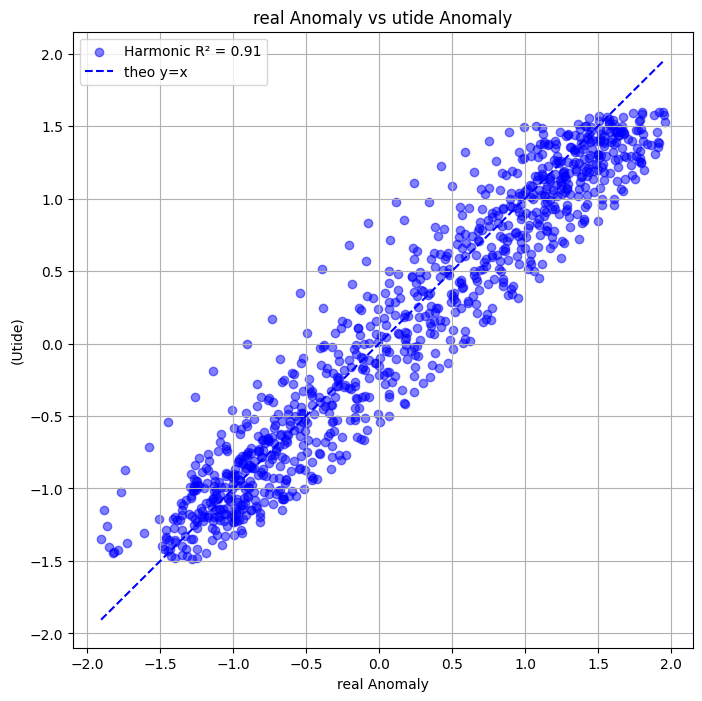

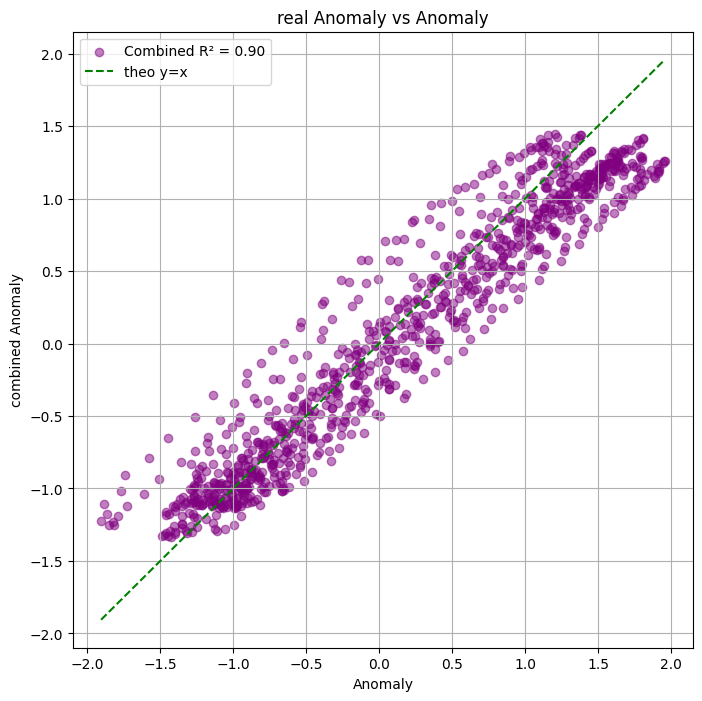

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input, Layer
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

np.random.seed(5)

# attention
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

input_file = "dataProcessed/ABE5Y1_HA_processed.csv"
df = read_csv(input_file, delimiter=',')
total_length = len(df)
print(f"total length：{total_length}")

num_points = 12000
if len(df) >= num_points:
    df = df.iloc[-num_points:]
else:
    raise ValueError("less data")
feature_columns = ['anomaly', 'utide']
dataset = df[feature_columns].values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)
train_size = 11000
test_size = 1000
train, test = dataset_scaled[:train_size], dataset_scaled[train_size:train_size + test_size]

print(f"train set: {train.shape[0]}, test set: {test.shape[0]}")
look_back = 30
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(f"trainX: {trainX.shape}, trainY: {trainY.shape}")
print(f"testX: {testX.shape}, testY: {testY.shape}")
num_features = trainX.shape[2]
learning_rate = 0.001
weight_decay = 0.0001
#model
input_layer = Input(shape=(look_back, num_features))
x = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(weight_decay)))(input_layer)
#x = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(weight_decay)))(x)
x = Attention()(x)
x = Dropout(0.4)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)
def scheduler(epoch, lr):
    if epoch % 50 == 0 and epoch != 0:
        lr = lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

#train
history = model.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=200,
    batch_size=512,
    verbose=1,
    callbacks=[reduce_lr, lr_scheduler]
)

#lossfunction
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.title('loss function')
plt.legend()
plt.show()

#rolling forcast
current_input = testX[0].copy()  # 形状为 (look_back, num_features)
utide_test = test[:, 1]
rolling_predictions = []
for i in range(len(testY)):
    current_input_reshaped = current_input.reshape(1, look_back, num_features)
    prediction = model.predict(current_input_reshaped, verbose=0)
    rolling_predictions.append(prediction[0, 0])
    current_input = np.roll(current_input, -1, axis=0)
    current_input[-1, 0] = prediction[0, 0]
    current_input[-1, 1] = utide_test[look_back + i]

rolling_predictions = np.array(rolling_predictions)
predictions_full = np.zeros((len(rolling_predictions), num_features))
predictions_full[:, 0] = rolling_predictions
predictions_full[:, 1] = test[look_back:, 1]

testY_full = np.zeros((len(testY), num_features))
testY_full[:, 0] = testY
testY_full[:, 1] = test[look_back:, 1]
#inverse
predictions_inverse = scaler.inverse_transform(predictions_full)[:, 0]
testY_inverse = scaler.inverse_transform(testY_full)[:, 0]
utide_inverse = scaler.inverse_transform(test[look_back:])[:, 1]

#evaluate
rmse = math.sqrt(mean_squared_error(testY_inverse, predictions_inverse))
mae = mean_absolute_error(testY_inverse, predictions_inverse)
r2 = r2_score(testY_inverse, predictions_inverse)

aligned_utide = utide_inverse
error_anomaly = testY_inverse - predictions_inverse
error_utide = testY_inverse - utide_inverse


#weighted average
ls = 0.5
ha = 0.5


combined_predictions_inverse = ls * predictions_inverse + ha * aligned_utide


rmse_combined = math.sqrt(mean_squared_error(testY_inverse, combined_predictions_inverse))
mae_combined = mean_absolute_error(testY_inverse, combined_predictions_inverse)
r2_combined = r2_score(testY_inverse, combined_predictions_inverse)
error_combined = testY_inverse - combined_predictions_inverse

plt.figure(figsize=(18, 6))
plt.plot(error_anomaly, label='LSTM_error (Anomaly)', color='red')
plt.plot(error_utide, label='utide_error (Anomaly vs Utide)', color='blue')
plt.plot(error_combined, label='combined error', color='purple')
plt.xlabel('time step')
plt.ylabel('error')
plt.title('error compare')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 10))
plt.plot(testY_inverse, label="real (Anomaly)")
plt.plot(predictions_inverse, label="LSTM_predicted (Anomaly)", color='red', linestyle="--")
plt.plot(aligned_utide, label="(Utide)", color='blue', linestyle="--", linewidth=1.5)
plt.xlabel("time step")
plt.ylabel("Anomaly")
plt.title("real vs predicted vs utide")
plt.legend()
plt.show()



plt.figure(figsize=(18, 10))
plt.plot(testY_inverse, label="real (Anomaly)")
plt.plot(combined_predictions_inverse, label="combined (LSTM & Utide)", color='purple', linestyle="--")
plt.xlabel("time step")
plt.ylabel("Anomaly")
plt.title("combined (LSTM & Utide)")
plt.legend()
plt.show()

#error_combined = testY_inverse - combined_predictions_inverse

# plt.figure(figsize=(18, 6))
# plt.plot(error_combined, label='combined error', color='purple')
# plt.xlabel('time step')
# plt.ylabel('error')
# plt.title('combined error')
# plt.legend()
# plt.grid(True)
# plt.show()



print("LSTM eva：")
print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')
print(f'Test R²: {r2:.2f}')

print("\neva：")
harmonic_rmse = math.sqrt(mean_squared_error(testY_inverse, utide_inverse))
harmonic_mae = mean_absolute_error(testY_inverse, utide_inverse)
harmonic_r2 = r2_score(testY_inverse, utide_inverse)
print(f'Harmonic RMSE: {harmonic_rmse:.2f}')
print(f'Harmonic MAE: {harmonic_mae:.2f}')
print(f'Harmonic R²: {harmonic_r2:.2f}')

print("\nweighted combined：")
print(f'Combined RMSE: {rmse_combined:.2f}')
print(f'Combined MAE: {mae_combined:.2f}')
print(f'Combined R²: {r2_combined:.2f}')

plt.figure(figsize=(8, 8))
plt.scatter(testY_inverse, predictions_inverse, alpha=0.5, label=f'LSTM R² = {r2:.2f}', color='red')
plt.plot([testY_inverse.min(), testY_inverse.max()], [testY_inverse.min(), testY_inverse.max()], 'r--', label='theo y=x')
plt.xlabel('real Anomaly')
plt.ylabel('prediceted Anomaly')
plt.title('real Anomaly vs LSTM predicted Anomaly')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(testY_inverse, utide_inverse, alpha=0.5, label=f'Harmonic R² = {harmonic_r2:.2f}', color='blue')
plt.plot([testY_inverse.min(), testY_inverse.max()], [testY_inverse.min(), testY_inverse.max()], 'b--', label='theo y=x')
plt.xlabel('real Anomaly')
plt.ylabel('(Utide)')
plt.title('real Anomaly vs utide Anomaly')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(testY_inverse, combined_predictions_inverse, alpha=0.5, label=f'Combined R² = {r2_combined:.2f}', color='purple')
plt.plot([testY_inverse.min(), testY_inverse.max()], [testY_inverse.min(), testY_inverse.max()], 'g--', label='theo y=x')
plt.xlabel('Anomaly')
plt.ylabel('combined Anomaly')
plt.title('real Anomaly vs Anomaly')
plt.legend()
plt.grid(True)
plt.show()


Iteration 1/10
Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0589 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0051 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0042 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 9.2629e-04 - learning_rate: 0.0010
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - val_loss: 8.2827e-04 - learning_rate: 0.0010
Epoch 8/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024 - val_loss: 7.4534e-04 - learning_rate: 0.0010
Epoch 9/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022 - val_loss: 6.7856e-04 - l

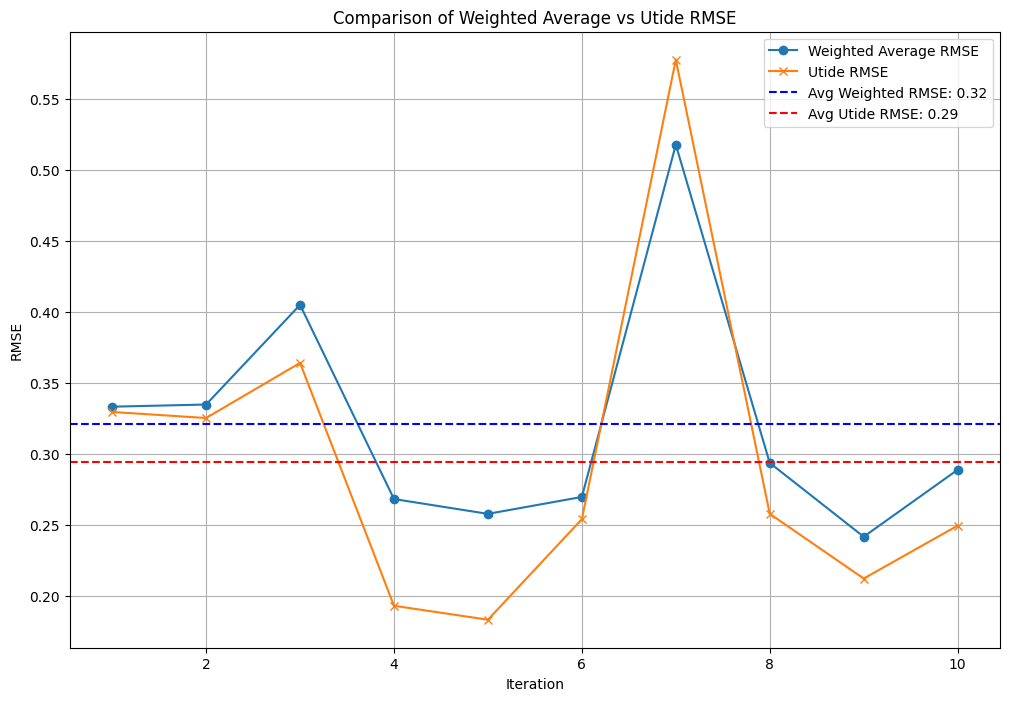

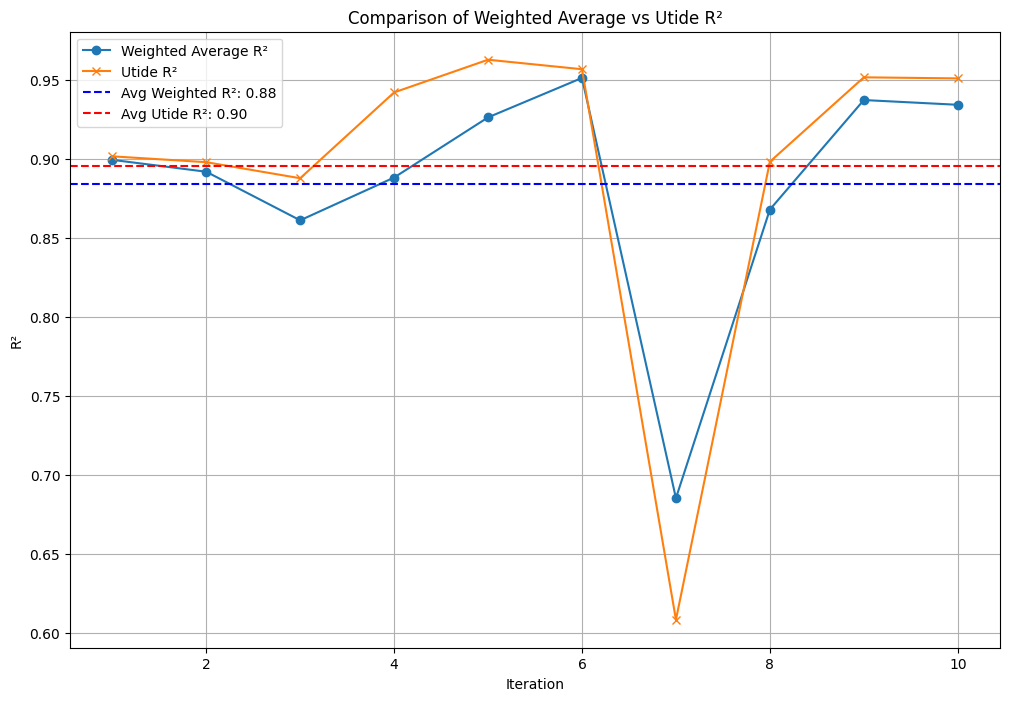

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import time


np.random.seed(5)
input_file = "dataProcessed/ABE5Y1_HA_processed.csv"
df = read_csv(input_file, delimiter=',')
feature_columns = ['anomaly', 'utide']
dataset = df[feature_columns].values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)
#---------------------------------------------------------------lookback
look_back = 50
train_size = 11000
test_size = 1000
num_points = train_size + test_size

ls = 0.5
ha = 0.5

weighted_errors_rmse = []
utide_errors_rmse = []
weighted_errors_r2 = []
utide_errors_r2 = []


def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])  # 目标是下一个时间步的 anomaly
    return np.array(dataX), np.array(dataY)

# x time iteration
for iteration in range(10):
    print(f"Iteration {iteration + 1}/10")
    total_length = len(dataset_scaled)
    max_start_index = total_length - num_points
    start_index = np.random.randint(0, max_start_index + 1)
    selected_data = dataset_scaled[start_index:start_index + num_points]
    train, test = selected_data[:train_size], selected_data[train_size:train_size + test_size]
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    num_features = trainX.shape[2]

    #model-------------------------------------------------
    input_layer = Input(shape=(look_back, num_features))
    x = Bidirectional(LSTM(250, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.4)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer)
    #dynamic lr
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)

    # train-------------------------------------------------
    model.fit(trainX, trainY, validation_split=0.1, epochs=150, batch_size=512, verbose=1, callbacks=[reduce_lr])

    # rolling forcast
    current_input = testX[0].copy()
    utide_test = test[:, 1]
    rolling_predictions = []
    for i in range(len(testY)):
        current_input_reshaped = current_input.reshape(1, look_back, num_features)
        prediction = model.predict(current_input_reshaped, verbose=0)
        rolling_predictions.append(prediction[0, 0])
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = prediction[0, 0]
        current_input[-1, 1] = utide_test[look_back + i]

    rolling_predictions = np.array(rolling_predictions)

    # inverse
    predictions_full = np.zeros((len(rolling_predictions), num_features))
    predictions_full[:, 0] = rolling_predictions
    predictions_full[:, 1] = test[look_back:, 1]

    testY_full = np.zeros((len(testY), num_features))
    testY_full[:, 0] = testY
    testY_full[:, 1] = test[look_back:, 1]

    predictions_inverse = scaler.inverse_transform(predictions_full)[:, 0]
    testY_inverse = scaler.inverse_transform(testY_full)[:, 0]
    utide_inverse = scaler.inverse_transform(test[look_back:])[:, 1]

    combined_predictions_inverse = ls * predictions_inverse + ha * utide_inverse

    # eva
    rmse_weighted = math.sqrt(mean_squared_error(testY_inverse, combined_predictions_inverse))
    rmse_utide = math.sqrt(mean_squared_error(testY_inverse, utide_inverse))
    r2_weighted = r2_score(testY_inverse, combined_predictions_inverse)
    r2_utide = r2_score(testY_inverse, utide_inverse)

    weighted_errors_rmse.append(rmse_weighted)
    utide_errors_rmse.append(rmse_utide)
    weighted_errors_r2.append(r2_weighted)
    utide_errors_r2.append(r2_utide)

    print(f"Weighted Average RMSE: {rmse_weighted:.2f}, R²: {r2_weighted:.2f}")
    print(f"Utide RMSE: {rmse_utide:.2f}, R²: {r2_utide:.2f}")


avg_weighted_rmse = np.mean(weighted_errors_rmse)
avg_utide_rmse = np.mean(utide_errors_rmse)
avg_weighted_r2 = np.mean(weighted_errors_r2)
avg_utide_r2 = np.mean(utide_errors_r2)


print(f"Weighted Average RMSE (Mean over 10 runs): {avg_weighted_rmse:.2f}, R²: {avg_weighted_r2:.2f}")
print(f"Utide RMSE (Mean over 10 runs): {avg_utide_rmse:.2f}, R²: {avg_utide_r2:.2f}")


plt.figure(figsize=(12, 8))
x_ticks = range(1, 11)
plt.plot(x_ticks, weighted_errors_rmse, marker='o', label='Weighted Average RMSE')
plt.plot(x_ticks, utide_errors_rmse, marker='x', label='Utide RMSE')
plt.axhline(avg_weighted_rmse, color='blue', linestyle='--', label=f'Avg Weighted RMSE: {avg_weighted_rmse:.2f}')
plt.axhline(avg_utide_rmse, color='red', linestyle='--', label=f'Avg Utide RMSE: {avg_utide_rmse:.2f}')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Comparison of Weighted Average vs Utide RMSE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(x_ticks, weighted_errors_r2, marker='o', label='Weighted Average R²')
plt.plot(x_ticks, utide_errors_r2, marker='x', label='Utide R²')
plt.axhline(avg_weighted_r2, color='blue', linestyle='--', label=f'Avg Weighted R²: {avg_weighted_r2:.2f}')
plt.axhline(avg_utide_r2, color='red', linestyle='--', label=f'Avg Utide R²: {avg_utide_r2:.2f}')
plt.xlabel('Iteration')
plt.ylabel('R²')
plt.title('Comparison of Weighted Average vs Utide R²')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0957 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044 - val_loss: 9.9614e-04 - learning_rate: 0.0010
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 9.5334e-04 - learning_rate: 0.0010
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 9.3411e-04 - learning_rate: 0.0010
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0014 - learning_ra

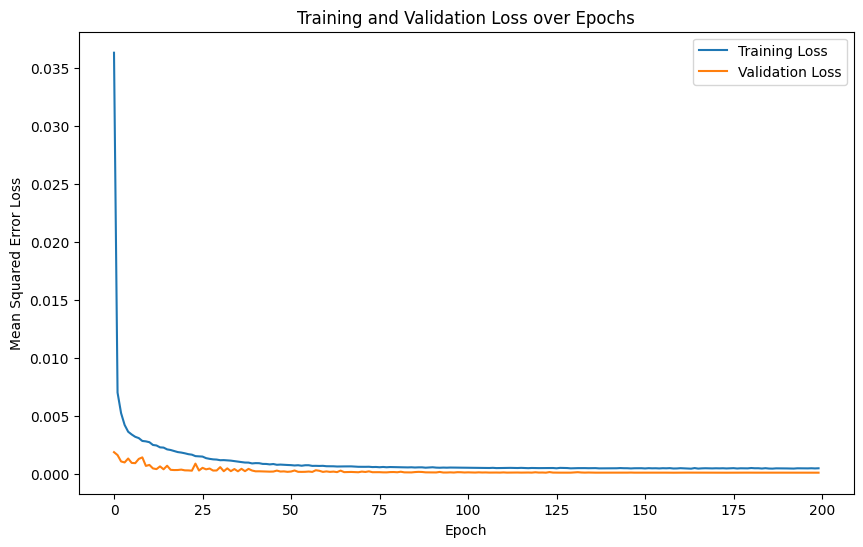

Model Prediction - Test RMSE: 0.41
Model Prediction - Test MAE: 0.33
Model Prediction - Overall Pearson Correlation: 0.9358
Utide - Test RMSE: 0.29
Utide - Test MAE: 0.23


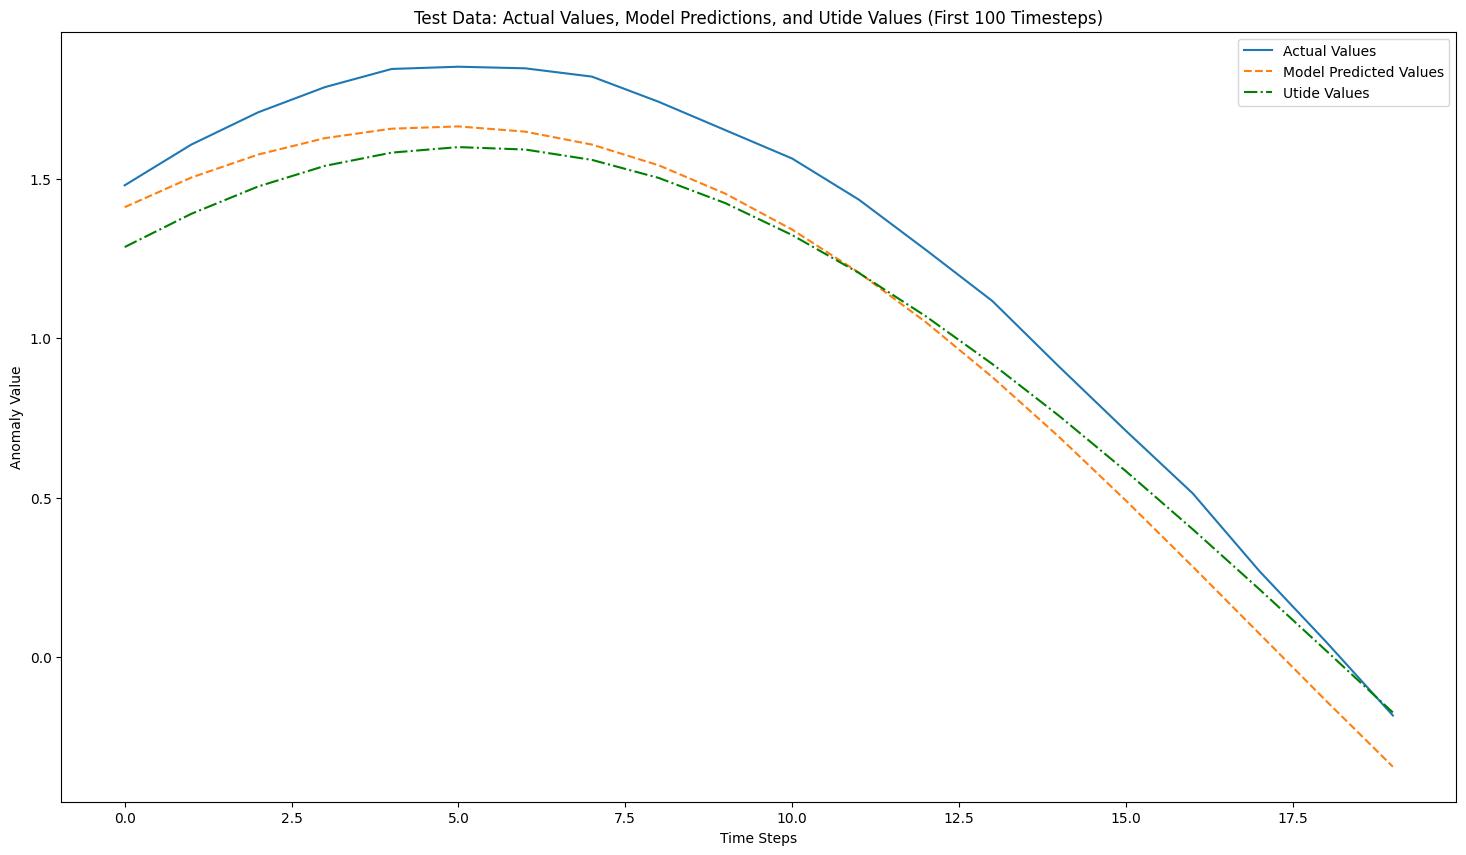

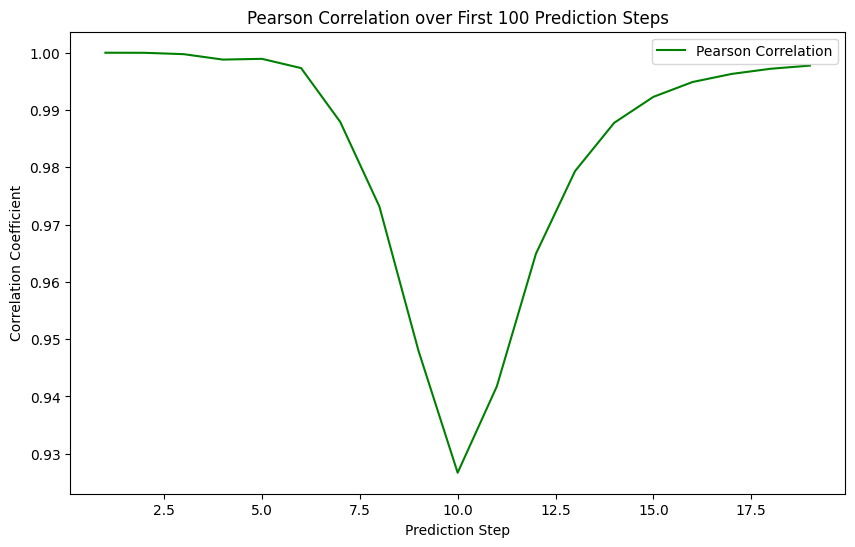

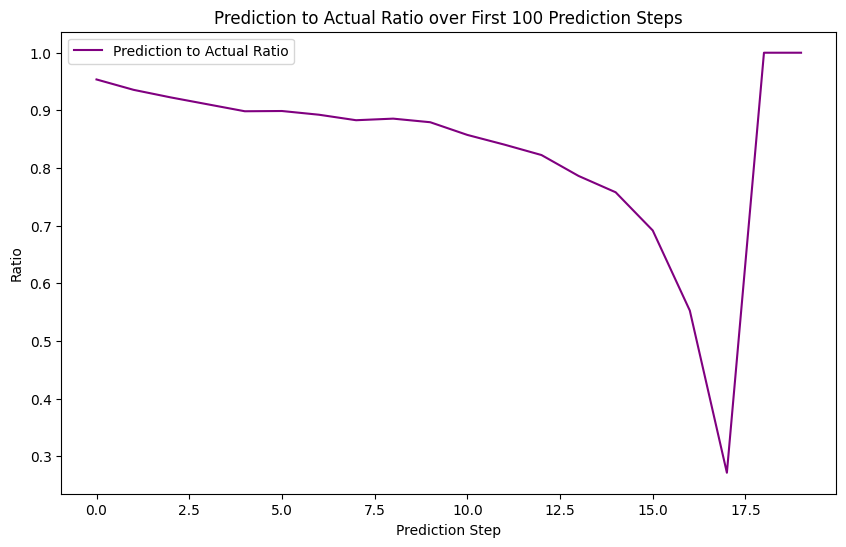

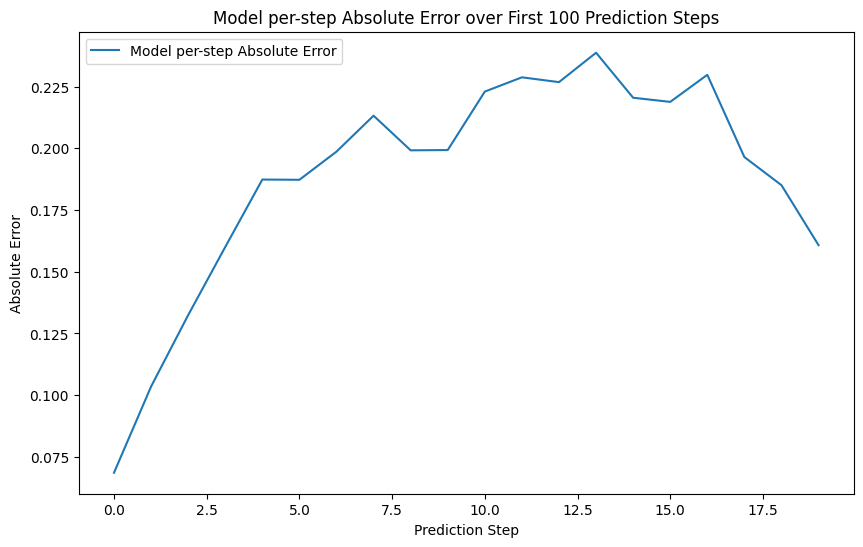

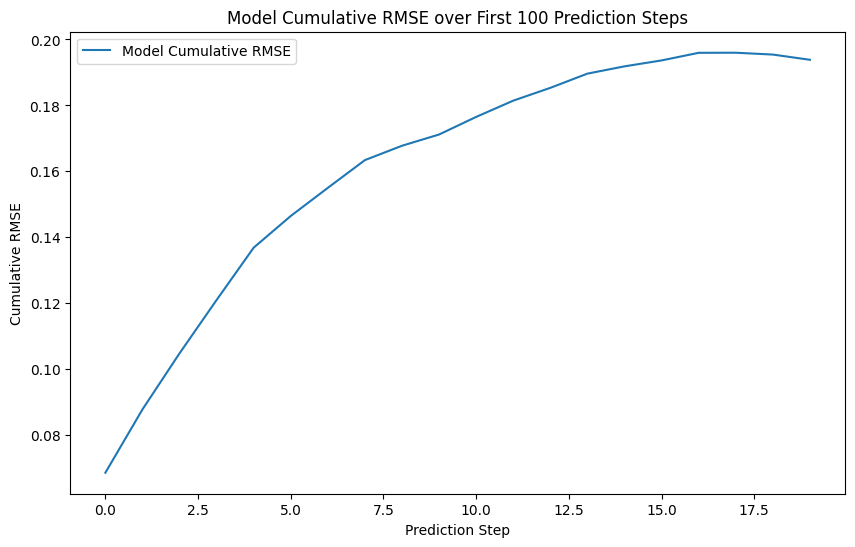

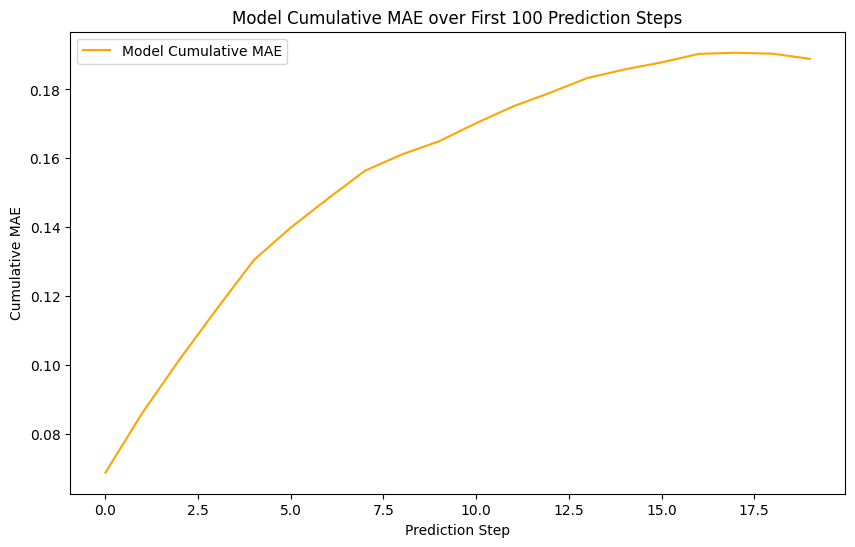

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Remove the fixed random seed to ensure different data each run
# np.random.seed(5)

# Define file path
input_file = "dataProcessed/ABE5Y1_HA_processed.csv"

# Load dataset
df = read_csv(input_file, delimiter=',')

# Define parameters
total_data_points = 10000
train_size = 9000
test_size = 1000
look_back = 30

# Check dataset size
total_required = total_data_points + look_back
if len(df) < total_required:
    raise ValueError(f"Dataset is too small. Requires at least {total_required} data points.")

# Randomly select a starting index to ensure continuity in the time series
max_start_index = len(df) - total_data_points - look_back
start_index = np.random.randint(0, max_start_index)
df_sampled = df.iloc[start_index:start_index + total_data_points + look_back].reset_index(drop=True)

# Extract features
anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide = df_sampled['utide'].values.reshape(-1, 1)

# Scale features separately
scaler_anomaly = MinMaxScaler(feature_range=(0, 1))
anomaly_scaled = scaler_anomaly.fit_transform(anomaly)

scaler_utide = MinMaxScaler(feature_range=(0, 1))
utide_scaled = scaler_utide.fit_transform(utide)

# Combine scaled features
dataset_scaled = np.hstack((anomaly_scaled, utide_scaled))

# Split dataset
train = dataset_scaled[:train_size]
test = dataset_scaled[train_size:train_size + test_size + look_back]  # Include look_back steps

# Create dataset function
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])  # Target is the next time step's anomaly
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Get the number of features
num_features = trainX.shape[2]

# Build BiLSTM model
learning_rate = 0.001
weight_decay = 0.0001

input_layer = Input(shape=(look_back, num_features))
x = Bidirectional(LSTM(50, kernel_regularizer=l2(weight_decay)))(input_layer)
x = Dropout(0.3)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)

# Train model with validation set
history = model.fit(trainX, trainY, validation_split=0.1, epochs=200, batch_size=64, verbose=1, callbacks=[reduce_lr])

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# ===========================
# Rolling Prediction on Test Set with error tracking and accuracy
# ===========================

# Initialize input sequence with the first test input sequence
current_input = testX[0]  # Shape: (look_back, num_features)

# Store predictions
rolling_predictions = []

# Initialize error and accuracy tracking variables
errors = []
cumulative_squared_error = 0
cumulative_abs_error = 0
cumulative_RMSEs = []
cumulative_MAEs = []
ratio_scores = []
pearson_corr_scores = []

# Initialize lists for metrics computation
actual_values = []
predicted_values = []
utide_actual_values = []
utide_predicted_values = []

# Rolling prediction over the test set
for i in range(len(testY)):
    # Prepare input data
    current_input_reshaped = current_input.reshape(1, look_back, num_features)

    # Predict the next time step anomaly
    prediction = model.predict(current_input_reshaped, verbose=0)

    # Store prediction
    rolling_predictions.append(prediction[0, 0])

    # Update input sequence
    current_input = np.roll(current_input, -1, axis=0)

    # Update the last row of the input sequence
    current_input[-1, 0] = prediction[0, 0]       # Use the predicted anomaly value
    current_input[-1, 1] = test[look_back + i, 1]  # Use known utide value

    # Inverse transform anomaly predictions and actual values
    prediction_inverse = scaler_anomaly.inverse_transform(prediction.reshape(-1, 1))[0, 0]
    actual_inverse = scaler_anomaly.inverse_transform(testY[i].reshape(-1, 1))[0, 0]

    # Inverse transform utide value
    utide_value = scaler_utide.inverse_transform(test[look_back + i, 1].reshape(-1, 1))[0, 0]

    # Store actual and predicted values
    actual_values.append(actual_inverse)
    predicted_values.append(prediction_inverse)

    # Store utide values for comparison
    utide_actual_values.append(actual_inverse)
    utide_predicted_values.append(utide_value)

    # Compute error
    error = actual_inverse - prediction_inverse
    abs_error = abs(error)
    squared_error = error ** 2

    # Track errors
    errors.append(abs_error)
    cumulative_squared_error += squared_error
    cumulative_abs_error += abs_error
    cumulative_RMSE = math.sqrt(cumulative_squared_error / (i + 1))
    cumulative_MAE = cumulative_abs_error / (i + 1)
    cumulative_RMSEs.append(cumulative_RMSE)
    cumulative_MAEs.append(cumulative_MAE)

    # Compute ratio of prediction to actual value
    if actual_inverse != 0:
        ratio = abs(prediction_inverse / actual_inverse)
        # Limit ratio between 0 and 1
        ratio = min(ratio, 1.0)
    else:
        ratio = np.nan  # Set to NaN if actual value is zero
    ratio_scores.append(ratio)

    # Compute Pearson Correlation Coefficient
    if i >= 1:
        y_true = np.array(actual_values[:i+1])
        y_pred = np.array(predicted_values[:i+1])
        corr_matrix = np.corrcoef(y_true, y_pred)
        pearson_corr = corr_matrix[0, 1]
        pearson_corr_scores.append(pearson_corr)
    else:
        pearson_corr_scores.append(np.nan)  # Cannot compute correlation with less than 2 points

# Convert lists to arrays for plotting
actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)
utide_predicted_values = np.array(utide_predicted_values)
ratio_scores = np.array(ratio_scores)
pearson_corr_scores = np.array(pearson_corr_scores)

# Compute overall RMSE and MAE for model predictions
rmse = math.sqrt(mean_squared_error(actual_values, predicted_values))
mae = mean_absolute_error(actual_values, predicted_values)
correlation_matrix = np.corrcoef(actual_values, predicted_values)
overall_pearson_corr = correlation_matrix[0, 1]

print(f'Model Prediction - Test RMSE: {rmse:.2f}')
print(f'Model Prediction - Test MAE: {mae:.2f}')
print(f'Model Prediction - Overall Pearson Correlation: {overall_pearson_corr:.4f}')

# Compute overall RMSE and MAE for utide
utide_rmse = math.sqrt(mean_squared_error(actual_values, utide_predicted_values))
utide_mae = mean_absolute_error(actual_values, utide_predicted_values)

print(f'Utide - Test RMSE: {utide_rmse:.2f}')
print(f'Utide - Test MAE: {utide_mae:.2f}')

# Plot actual values, model predictions, and utide values (First 100 timesteps)
plt.figure(figsize=(18, 10))
plt.plot(actual_values[:20], label="Actual Values")  # Actual test data
plt.plot(predicted_values[:20], label="Model Predicted Values", linestyle="--")  # Model predictions
plt.plot(utide_predicted_values[:20], label="Utide Values", linestyle="-.", color='green', linewidth=1.5)  # Utide values

plt.xlabel("Time Steps")
plt.ylabel("Anomaly Value")
plt.title("Test Data: Actual Values, Model Predictions, and Utide Values (First 100 Timesteps)")
plt.legend()
plt.show()

# Plot Pearson Correlation over prediction steps (First 100 timesteps)
plt.figure(figsize=(10, 6))
plt.plot(pearson_corr_scores[:20], label='Pearson Correlation', color='green')
plt.xlabel('Prediction Step')
plt.ylabel('Correlation Coefficient')
plt.title('Pearson Correlation over First 100 Prediction Steps')
plt.legend()
plt.show()

# Plot ratio of prediction to actual value (First 100 timesteps)
plt.figure(figsize=(10, 6))
plt.plot(ratio_scores[:20], label='Prediction to Actual Ratio', color='purple')
plt.xlabel('Prediction Step')
plt.ylabel('Ratio')
plt.title('Prediction to Actual Ratio over First 100 Prediction Steps')
plt.legend()
plt.show()

# Plot per-step absolute errors (model)
plt.figure(figsize=(10, 6))
plt.plot(errors[:20], label='Model per-step Absolute Error')
plt.xlabel('Prediction Step')
plt.ylabel('Absolute Error')
plt.title('Model per-step Absolute Error over First 100 Prediction Steps')
plt.legend()
plt.show()

# Plot cumulative RMSE over prediction steps (model)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_RMSEs[:20], label='Model Cumulative RMSE')
plt.xlabel('Prediction Step')
plt.ylabel('Cumulative RMSE')
plt.title('Model Cumulative RMSE over First 100 Prediction Steps')
plt.legend()
plt.show()

# Plot cumulative MAE over prediction steps (model)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_MAEs[:20], label='Model Cumulative MAE', color='orange')
plt.xlabel('Prediction Step')
plt.ylabel('Cumulative MAE')
plt.title('Model Cumulative MAE over First 100 Prediction Steps')
plt.legend()
plt.show()

Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0574 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0060 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0047 - val_loss: 9.4531e-04 - learning_rate: 0.0010
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038 - val_loss: 8.0206e-04 - learning_rate: 0.0010
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - val_loss: 6.5286e-04 - learning_rate: 0.0010
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - val_loss: 5.6303e-04 - learning_rate: 0.0010
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 6.8046e-04 - learning_rate: 0.0010
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 6.6480e-04 -

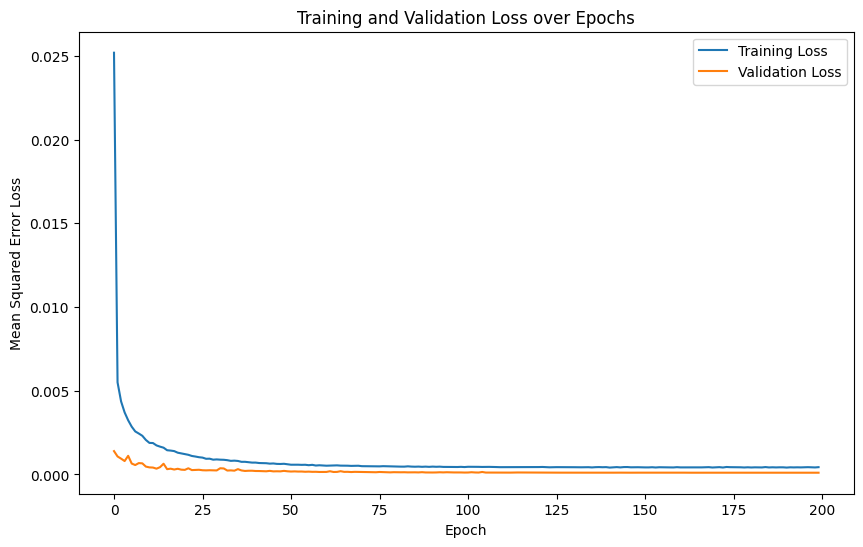

Model Prediction - Test RMSE: 0.43
Model Prediction - Test MAE: 0.34
Model Prediction - Overall Pearson Correlation: 0.9176
Utide - Test RMSE: 0.33
Utide - Test MAE: 0.23
Utide - Overall Pearson Correlation: 0.9525


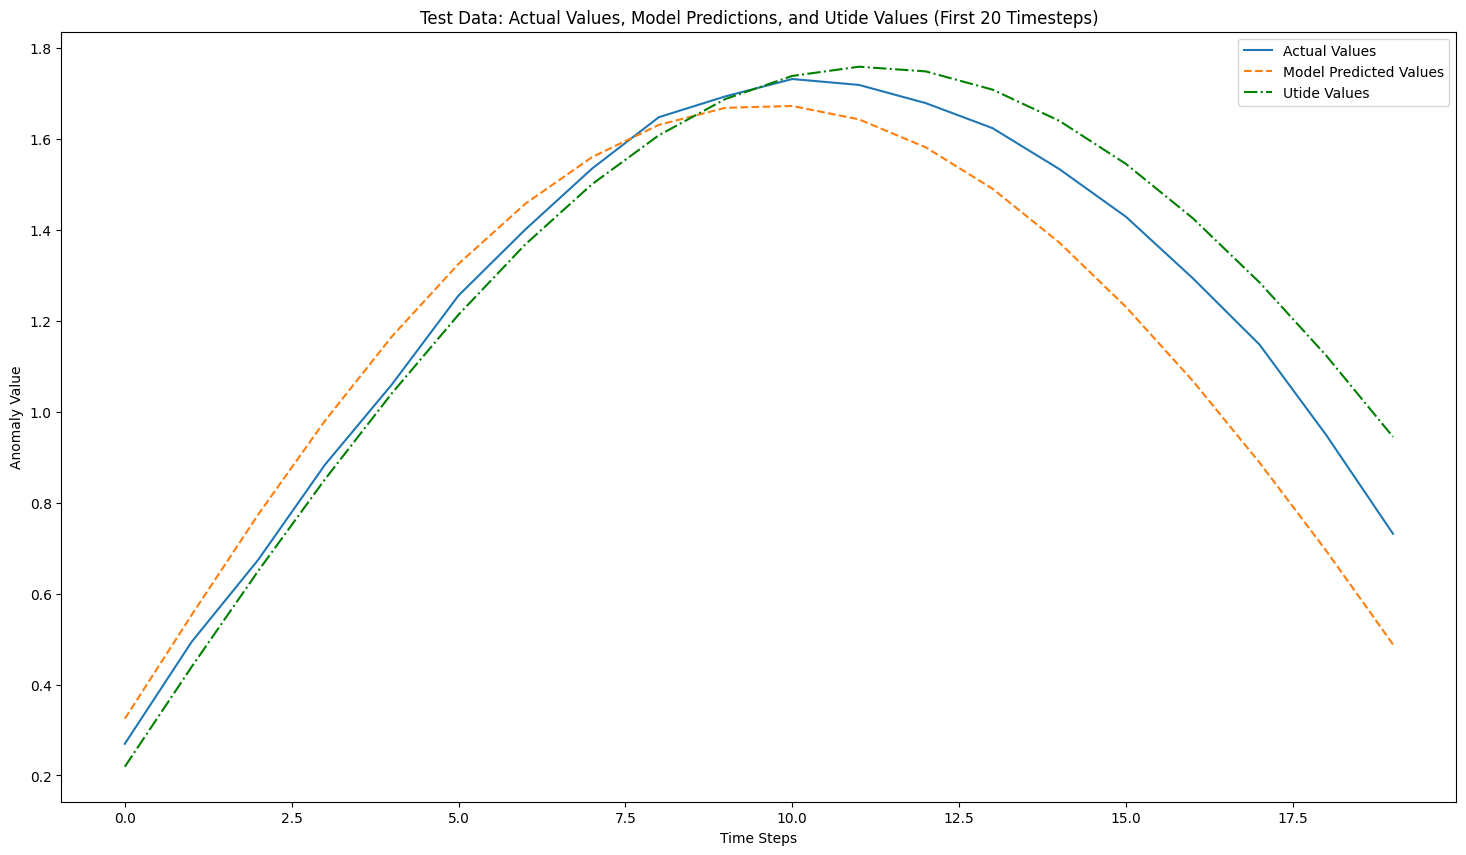

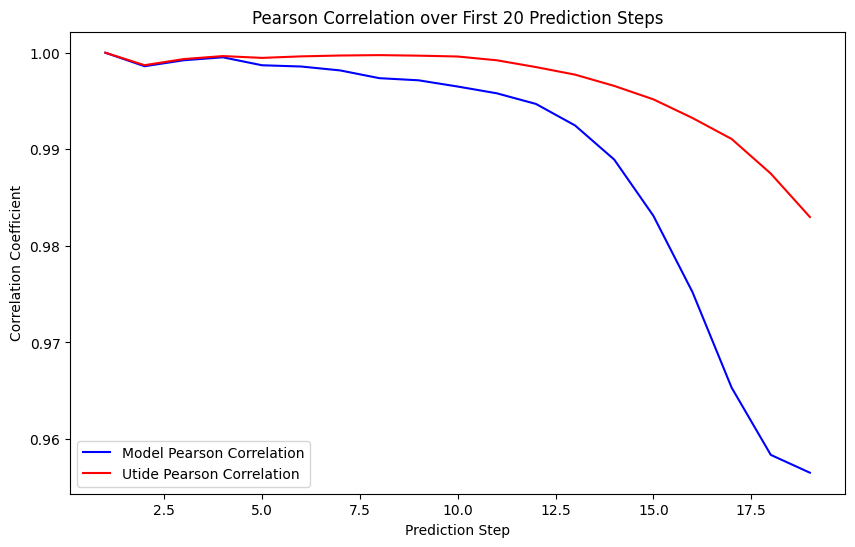

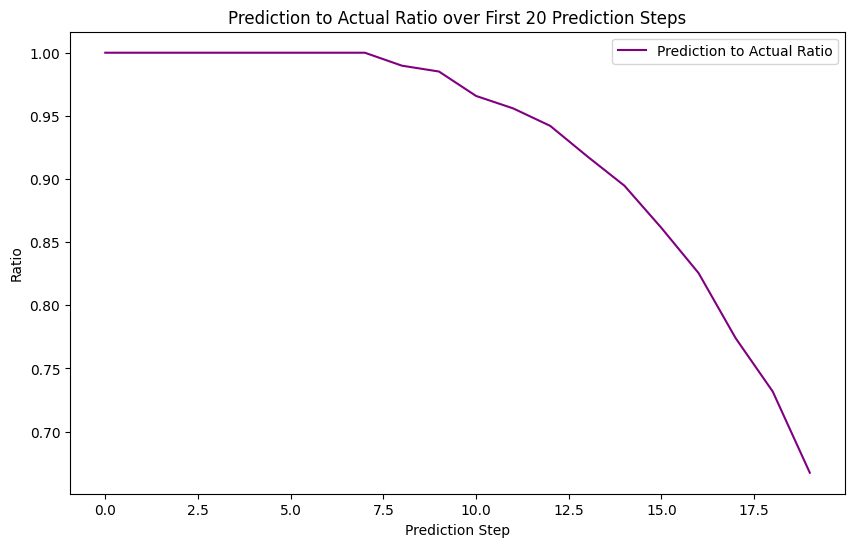

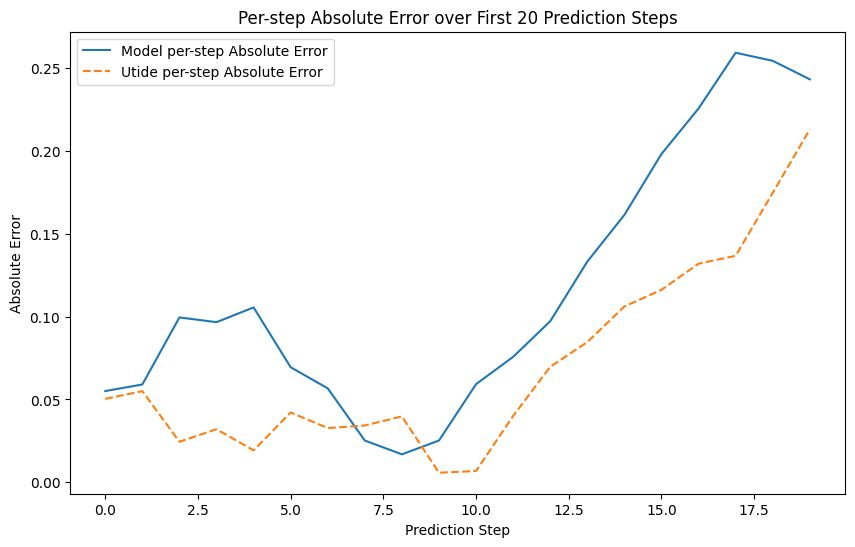

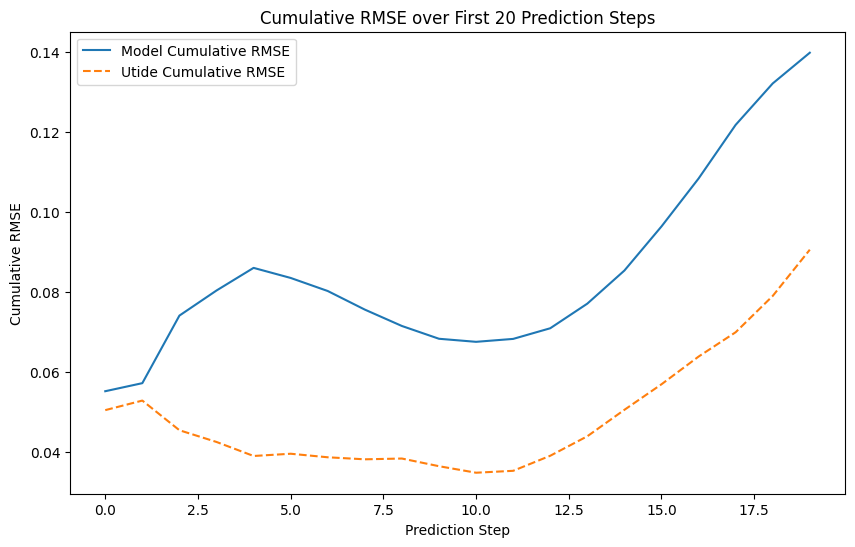

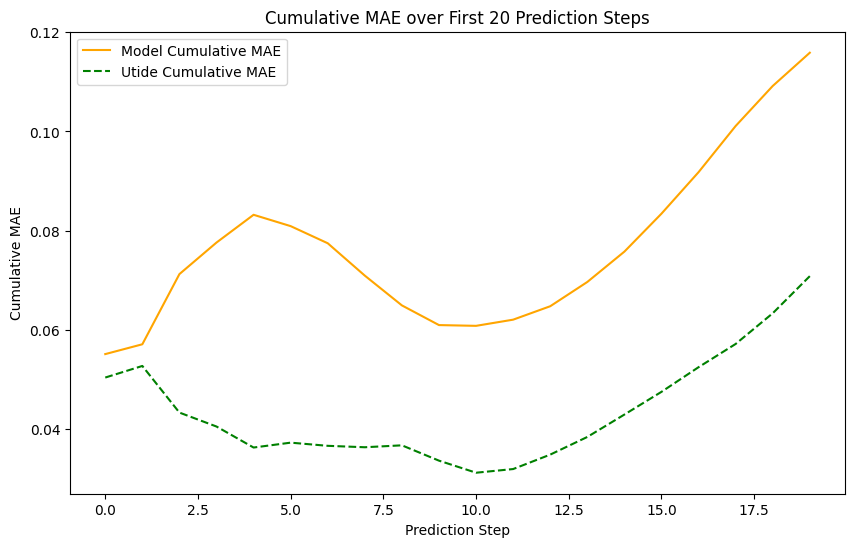

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Remove the fixed random seed to ensure different data each run
# np.random.seed(5)

# Define file path
input_file = "dataProcessed/ABE5Y1_HA_processed.csv"

# Load dataset
df = read_csv(input_file, delimiter=',')

# Define parameters
total_data_points = 10000
train_size = 9000
test_size = 1000
look_back = 30

# Check dataset size
total_required = total_data_points + look_back
if len(df) < total_required:
    raise ValueError(f"Dataset is too small. Requires at least {total_required} data points.")

# Randomly select a starting index to ensure continuity in the time series
max_start_index = len(df) - total_data_points - look_back
start_index = np.random.randint(0, max_start_index)
df_sampled = df.iloc[start_index:start_index + total_data_points + look_back].reset_index(drop=True)

# Extract features
anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide = df_sampled['utide'].values.reshape(-1, 1)

# Scale features separately
scaler_anomaly = MinMaxScaler(feature_range=(0, 1))
anomaly_scaled = scaler_anomaly.fit_transform(anomaly)

scaler_utide = MinMaxScaler(feature_range=(0, 1))
utide_scaled = scaler_utide.fit_transform(utide)

# Combine scaled features
dataset_scaled = np.hstack((anomaly_scaled, utide_scaled))

# Split dataset
train = dataset_scaled[:train_size]
test = dataset_scaled[train_size:train_size + test_size + look_back]  # Include look_back steps

# Create dataset function
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])  # Target is the next time step's anomaly
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Get the number of features
num_features = trainX.shape[2]

# Build BiLSTM model
learning_rate = 0.001
weight_decay = 0.0001

input_layer = Input(shape=(look_back, num_features))
x = Bidirectional(LSTM(50, kernel_regularizer=l2(weight_decay)))(input_layer)
x = Dropout(0.3)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)

# Train model with validation set
history = model.fit(trainX, trainY, validation_split=0.1, epochs=200, batch_size=64, verbose=1, callbacks=[reduce_lr])

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# ===========================
# Rolling Prediction on Test Set with error tracking and accuracy
# ===========================

# Initialize input sequence with the first test input sequence
current_input = testX[0]  # Shape: (look_back, num_features)

# Store predictions
rolling_predictions = []

# Initialize error and accuracy tracking variables
errors = []
utide_errors = []
cumulative_squared_error = 0
cumulative_abs_error = 0
cumulative_RMSEs = []
cumulative_MAEs = []
utide_cumulative_squared_error = 0
utide_cumulative_abs_error = 0
utide_cumulative_RMSEs = []
utide_cumulative_MAEs = []
ratio_scores = []
pearson_corr_scores = []
utide_pearson_corr_scores = []

# Initialize lists for metrics computation
actual_values = []
predicted_values = []
utide_predicted_values = []

# Rolling prediction over the test set
for i in range(len(testY)):
    # Prepare input data
    current_input_reshaped = current_input.reshape(1, look_back, num_features)

    # Predict the next time step anomaly
    prediction = model.predict(current_input_reshaped, verbose=0)

    # Store prediction
    rolling_predictions.append(prediction[0, 0])

    # Update input sequence
    current_input = np.roll(current_input, -1, axis=0)

    # Update the last row of the input sequence
    current_input[-1, 0] = prediction[0, 0]       # Use the predicted anomaly value
    current_input[-1, 1] = test[look_back + i, 1]  # Use known utide value

    # Inverse transform anomaly predictions and actual values
    prediction_inverse = scaler_anomaly.inverse_transform(prediction.reshape(-1, 1))[0, 0]
    actual_inverse = scaler_anomaly.inverse_transform(testY[i].reshape(-1, 1))[0, 0]

    # Inverse transform utide value
    utide_value = scaler_utide.inverse_transform(test[look_back + i, 1].reshape(-1, 1))[0, 0]

    # Store actual and predicted values
    actual_values.append(actual_inverse)
    predicted_values.append(prediction_inverse)
    utide_predicted_values.append(utide_value)

    # Compute model error
    error = actual_inverse - prediction_inverse
    abs_error = abs(error)
    squared_error = error ** 2

    # Compute utide error
    utide_error = actual_inverse - utide_value
    utide_abs_error = abs(utide_error)
    utide_squared_error = utide_error ** 2

    # Track model errors
    errors.append(abs_error)
    cumulative_squared_error += squared_error
    cumulative_abs_error += abs_error
    cumulative_RMSE = math.sqrt(cumulative_squared_error / (i + 1))
    cumulative_MAE = cumulative_abs_error / (i + 1)
    cumulative_RMSEs.append(cumulative_RMSE)
    cumulative_MAEs.append(cumulative_MAE)

    # Track utide errors
    utide_errors.append(utide_abs_error)
    utide_cumulative_squared_error += utide_squared_error
    utide_cumulative_abs_error += utide_abs_error
    utide_cumulative_RMSE = math.sqrt(utide_cumulative_squared_error / (i + 1))
    utide_cumulative_MAE = utide_cumulative_abs_error / (i + 1)
    utide_cumulative_RMSEs.append(utide_cumulative_RMSE)
    utide_cumulative_MAEs.append(utide_cumulative_MAE)

    # Compute ratio of prediction to actual value
    if actual_inverse != 0:
        ratio = abs(prediction_inverse / actual_inverse)
        # Limit ratio between 0 and 1
        ratio = min(ratio, 1.0)
    else:
        ratio = np.nan  # Set to NaN if actual value is zero
    ratio_scores.append(ratio)

    # Compute Pearson Correlation Coefficient for model predictions
    if i >= 1:
        y_true = np.array(actual_values[:i+1])
        y_pred = np.array(predicted_values[:i+1])
        corr_matrix = np.corrcoef(y_true, y_pred)
        pearson_corr = corr_matrix[0, 1]
        pearson_corr_scores.append(pearson_corr)
    else:
        pearson_corr_scores.append(np.nan)  # Cannot compute correlation with less than 2 points

    # Compute Pearson Correlation Coefficient for utide predictions
    if i >= 1:
        y_true_utide = np.array(actual_values[:i+1])
        y_pred_utide = np.array(utide_predicted_values[:i+1])
        corr_matrix_utide = np.corrcoef(y_true_utide, y_pred_utide)
        pearson_corr_utide = corr_matrix_utide[0, 1]
        utide_pearson_corr_scores.append(pearson_corr_utide)
    else:
        utide_pearson_corr_scores.append(np.nan)  # Cannot compute correlation with less than 2 points

# Convert lists to arrays for plotting
actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)
utide_predicted_values = np.array(utide_predicted_values)
errors = np.array(errors)
utide_errors = np.array(utide_errors)
cumulative_RMSEs = np.array(cumulative_RMSEs)
cumulative_MAEs = np.array(cumulative_MAEs)
utide_cumulative_RMSEs = np.array(utide_cumulative_RMSEs)
utide_cumulative_MAEs = np.array(utide_cumulative_MAEs)
ratio_scores = np.array(ratio_scores)
pearson_corr_scores = np.array(pearson_corr_scores)
utide_pearson_corr_scores = np.array(utide_pearson_corr_scores)

# Compute overall RMSE and MAE for model predictions
rmse = math.sqrt(mean_squared_error(actual_values, predicted_values))
mae = mean_absolute_error(actual_values, predicted_values)
correlation_matrix = np.corrcoef(actual_values, predicted_values)
overall_pearson_corr = correlation_matrix[0, 1]

print(f'Model Prediction - Test RMSE: {rmse:.2f}')
print(f'Model Prediction - Test MAE: {mae:.2f}')
print(f'Model Prediction - Overall Pearson Correlation: {overall_pearson_corr:.4f}')

# Compute overall RMSE and MAE for utide
utide_rmse = math.sqrt(mean_squared_error(actual_values, utide_predicted_values))
utide_mae = mean_absolute_error(actual_values, utide_predicted_values)
correlation_matrix_utide = np.corrcoef(actual_values, utide_predicted_values)
overall_pearson_corr_utide = correlation_matrix_utide[0, 1]

print(f'Utide - Test RMSE: {utide_rmse:.2f}')
print(f'Utide - Test MAE: {utide_mae:.2f}')
print(f'Utide - Overall Pearson Correlation: {overall_pearson_corr_utide:.4f}')

# Plot actual values, model predictions, and utide values (First 20 timesteps)
plt.figure(figsize=(18, 10))
plt.plot(actual_values[:20], label="Actual Values")  # Actual test data
plt.plot(predicted_values[:20], label="Model Predicted Values", linestyle="--")  # Model predictions
plt.plot(utide_predicted_values[:20], label="Utide Values", linestyle="-.", color='green', linewidth=1.5)  # Utide values

plt.xlabel("Time Steps")
plt.ylabel("Anomaly Value")
plt.title("Test Data: Actual Values, Model Predictions, and Utide Values (First 20 Timesteps)")
plt.legend()
plt.show()

# Plot Pearson Correlation over prediction steps (First 20 timesteps)
plt.figure(figsize=(10, 6))
plt.plot(pearson_corr_scores[:20], label='Model Pearson Correlation', color='blue')
plt.plot(utide_pearson_corr_scores[:20], label='Utide Pearson Correlation', color='red')
plt.xlabel('Prediction Step')
plt.ylabel('Correlation Coefficient')
plt.title('Pearson Correlation over First 20 Prediction Steps')
plt.legend()
plt.show()

# Plot ratio of prediction to actual value (First 20 timesteps)
plt.figure(figsize=(10, 6))
plt.plot(ratio_scores[:20], label='Prediction to Actual Ratio', color='purple')
plt.xlabel('Prediction Step')
plt.ylabel('Ratio')
plt.title('Prediction to Actual Ratio over First 20 Prediction Steps')
plt.legend()
plt.show()

# Plot per-step absolute errors (First 20 timesteps)
plt.figure(figsize=(10, 6))
plt.plot(errors[:20], label='Model per-step Absolute Error')
plt.plot(utide_errors[:20], label='Utide per-step Absolute Error', linestyle='--')
plt.xlabel('Prediction Step')
plt.ylabel('Absolute Error')
plt.title('Per-step Absolute Error over First 20 Prediction Steps')
plt.legend()
plt.show()

# Plot cumulative RMSE over prediction steps (First 20 timesteps)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_RMSEs[:20], label='Model Cumulative RMSE')
plt.plot(utide_cumulative_RMSEs[:20], label='Utide Cumulative RMSE', linestyle='--')
plt.xlabel('Prediction Step')
plt.ylabel('Cumulative RMSE')
plt.title('Cumulative RMSE over First 20 Prediction Steps')
plt.legend()
plt.show()

# Plot cumulative MAE over prediction steps (First 20 timesteps)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_MAEs[:20], label='Model Cumulative MAE', color='orange')
plt.plot(utide_cumulative_MAEs[:20], label='Utide Cumulative MAE', color='green', linestyle='--')
plt.xlabel('Prediction Step')
plt.ylabel('Cumulative MAE')
plt.title('Cumulative MAE over First 20 Prediction Steps')
plt.legend()
plt.show()

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1328 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0426 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0280 - val_loss: 0.0208 - learning_rate: 0.0010
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0210 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0175 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0152 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0136 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0124 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0115 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 10/2

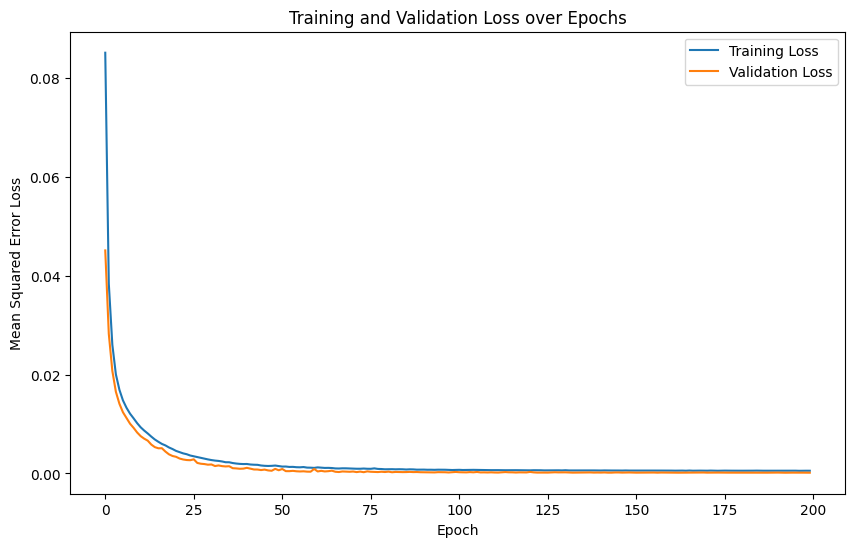

Model Prediction - Test RMSE: 1.82
Model Prediction - Test MAE: 1.48
Model Prediction - Overall Pearson Correlation: -0.1871
Utide - Test RMSE: 0.38
Utide - Test MAE: 0.26
Utide - Overall Pearson Correlation: 0.9382


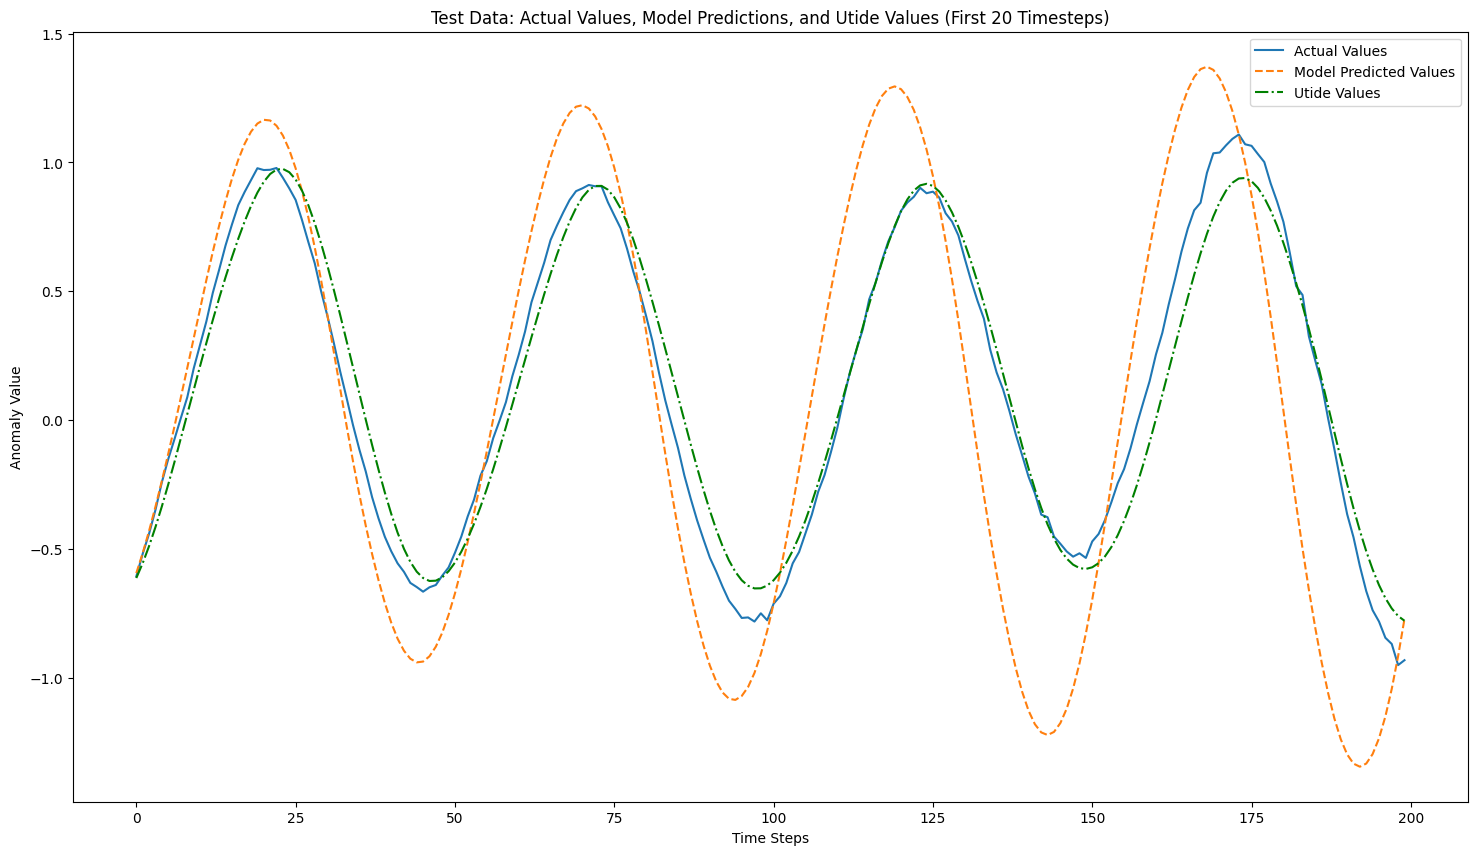

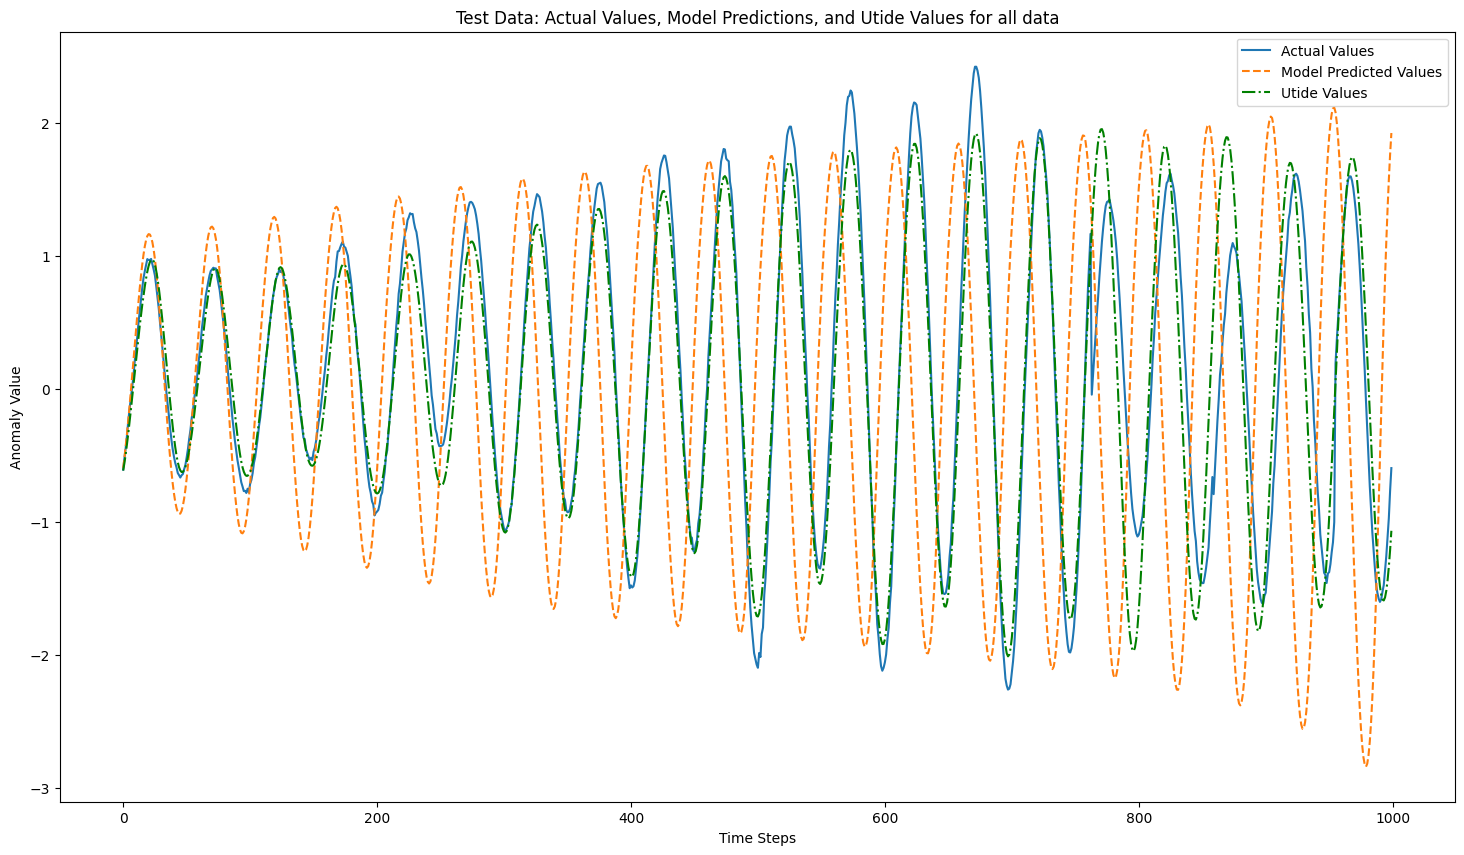

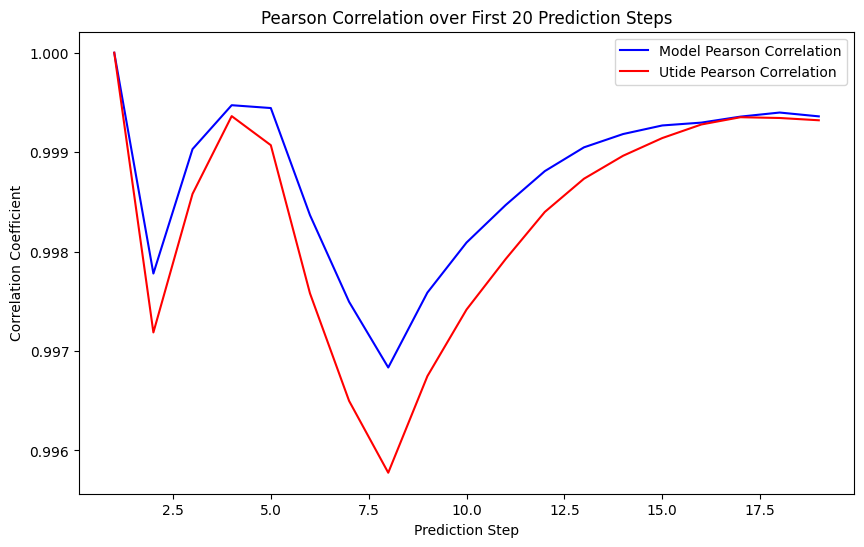

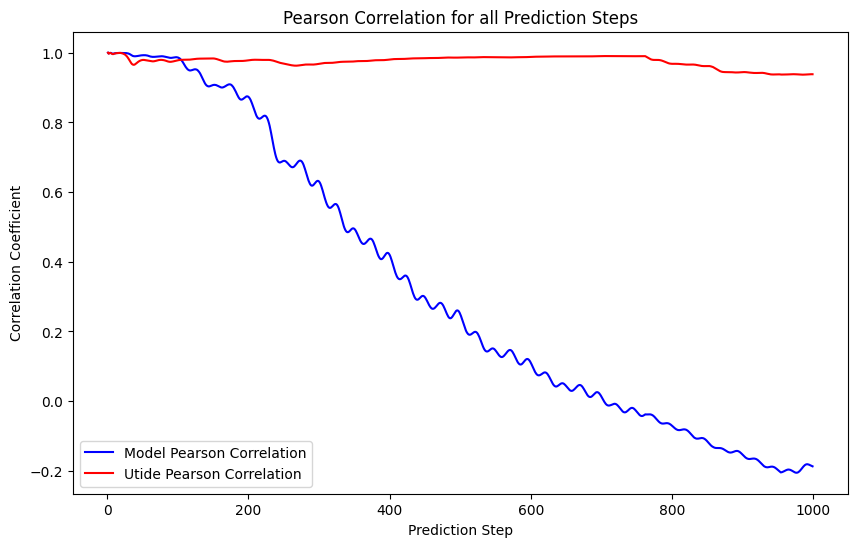

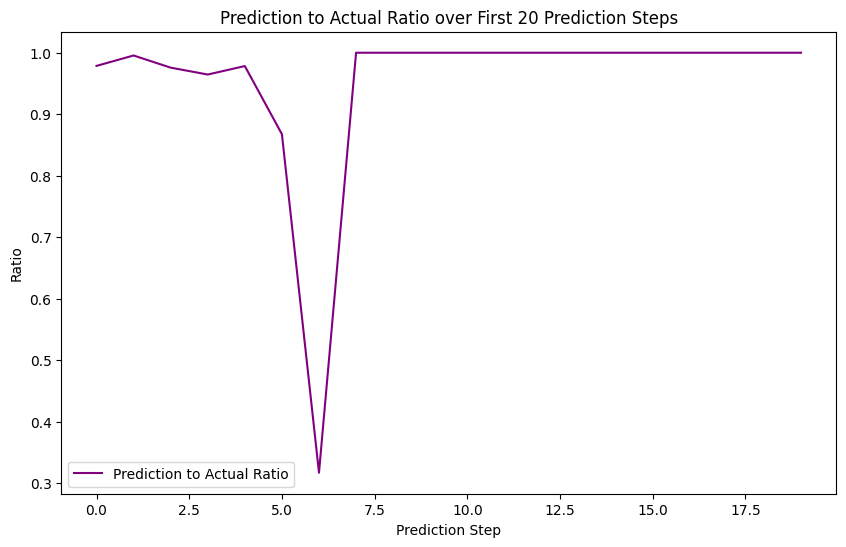

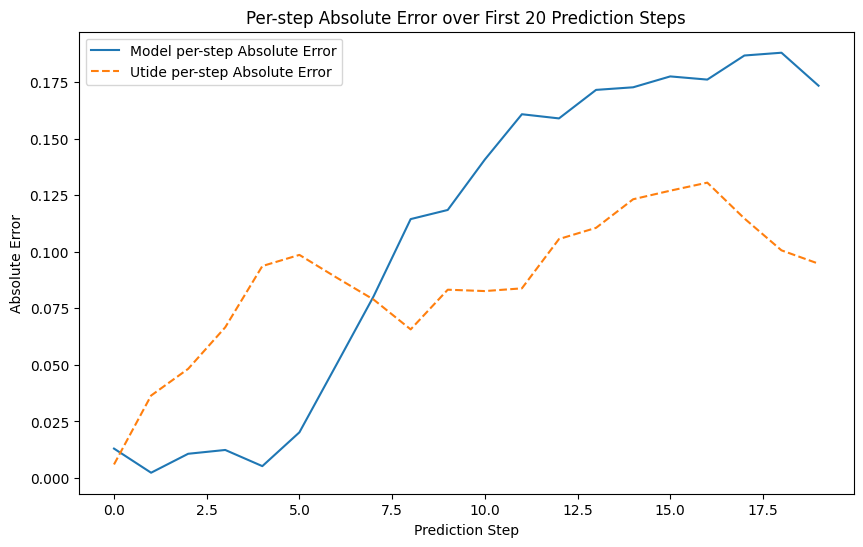

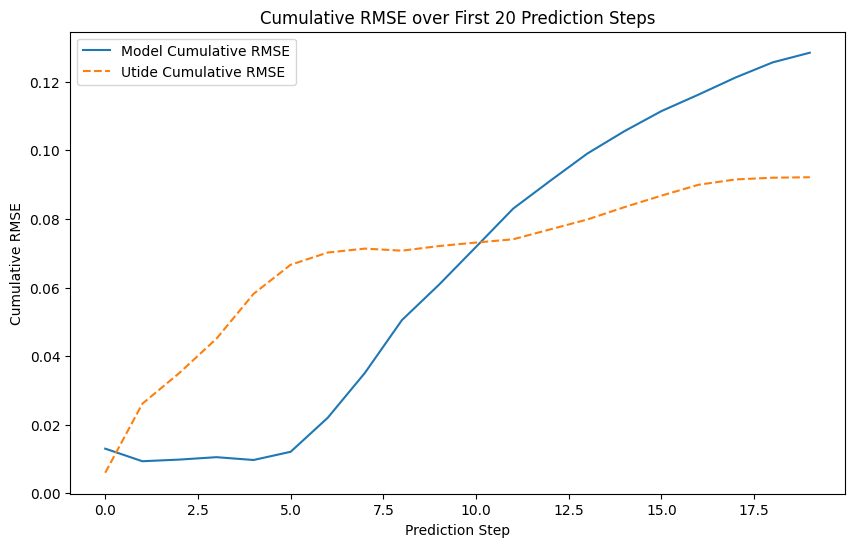

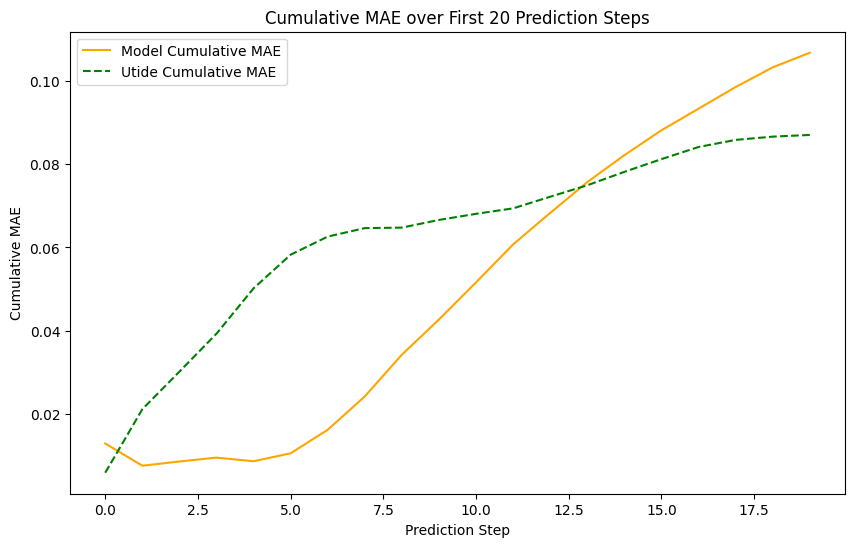

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Remove the fixed random seed to ensure different data each run
# np.random.seed(5)

# Define file path
input_file = "dataProcessed/ABE5Y1_HA_processed.csv"

# Load dataset
df = read_csv(input_file, delimiter=',')

# Define parameters
total_data_points = 10000
train_size = 9000
test_size = 1000
look_back = 100

# Check dataset size
total_required = total_data_points + look_back
if len(df) < total_required:
    raise ValueError(f"Dataset is too small. Requires at least {total_required} data points.")

# Randomly select a starting index to ensure continuity in the time series
max_start_index = len(df) - total_data_points - look_back
start_index = np.random.randint(0, max_start_index)
df_sampled = df.iloc[start_index:start_index + total_data_points + look_back].reset_index(drop=True)

# Extract features
anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide = df_sampled['utide'].values.reshape(-1, 1)

# Scale features separately
scaler_anomaly = MinMaxScaler(feature_range=(0, 1))
anomaly_scaled = scaler_anomaly.fit_transform(anomaly)

scaler_utide = MinMaxScaler(feature_range=(0, 1))
utide_scaled = scaler_utide.fit_transform(utide)

# Combine scaled features (for consistency, although the model will only use anomaly)
dataset_scaled = np.hstack((anomaly_scaled, utide_scaled))

# Split dataset
train = dataset_scaled[:train_size]
test = dataset_scaled[train_size:train_size + test_size + look_back]  # Include look_back steps

# Create dataset function with feature_indices
def create_dataset(dataset, look_back, feature_indices):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # Select the desired features
        a = dataset[i:(i + look_back), feature_indices]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])  # Target is the next time step's anomaly
    return np.array(dataX), np.array(dataY)

# Create trainX and testX using only 'anomaly' feature (index 0)
trainX, trainY = create_dataset(train, look_back, feature_indices=[0])
testX, testY = create_dataset(test, look_back, feature_indices=[0])

# Get the number of features (should be 1)
num_features = trainX.shape[2]

# Build BiLSTM model
learning_rate = 0.001
weight_decay = 0.0001

input_layer = Input(shape=(look_back, num_features))
x = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2(weight_decay)))(input_layer)
x = Bidirectional(LSTM(100, kernel_regularizer=l2(weight_decay)))(x)
x = Dropout(0.4)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)

# Train model with validation set
history = model.fit(trainX, trainY, validation_split=0.1, epochs=200, batch_size=256, verbose=1, callbacks=[reduce_lr])

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# ===========================
# Rolling Prediction on Test Set with error tracking and accuracy
# ===========================

# Initialize input sequence with the first test input sequence
current_input = testX[0]  # Shape: (look_back, num_features)

# Store predictions
rolling_predictions = []

# Initialize error and accuracy tracking variables
errors = []
utide_errors = []
cumulative_squared_error = 0
cumulative_abs_error = 0
cumulative_RMSEs = []
cumulative_MAEs = []
utide_cumulative_squared_error = 0
utide_cumulative_abs_error = 0
utide_cumulative_RMSEs = []
utide_cumulative_MAEs = []
ratio_scores = []
pearson_corr_scores = []
utide_pearson_corr_scores = []

# Initialize lists for metrics computation
actual_values = []
predicted_values = []
utide_predicted_values = []

# Rolling prediction over the test set
for i in range(len(testY)):
    # Prepare input data
    current_input_reshaped = current_input.reshape(1, look_back, num_features)

    # Predict the next time step anomaly
    prediction = model.predict(current_input_reshaped, verbose=0)

    # Store prediction
    rolling_predictions.append(prediction[0, 0])

    # Update input sequence
    current_input = np.roll(current_input, -1, axis=0)

    # Update the last row of the input sequence
    current_input[-1, 0] = prediction[0, 0]       # Use the predicted anomaly value
    # Note: Since we have only one feature, no need to update utide value in current_input

    # Inverse transform anomaly predictions and actual values
    prediction_inverse = scaler_anomaly.inverse_transform(prediction.reshape(-1, 1))[0, 0]
    actual_inverse = scaler_anomaly.inverse_transform(testY[i].reshape(-1, 1))[0, 0]

    # Inverse transform utide value
    utide_scaled_value = test[look_back + i, 1]  # Get the utide_scaled value from test set
    utide_value = scaler_utide.inverse_transform(utide_scaled_value.reshape(-1, 1))[0, 0]

    # Store actual and predicted values
    actual_values.append(actual_inverse)
    predicted_values.append(prediction_inverse)
    utide_predicted_values.append(utide_value)

    # Compute model error
    error = actual_inverse - prediction_inverse
    abs_error = abs(error)
    squared_error = error ** 2

    # Compute utide error
    utide_error = actual_inverse - utide_value
    utide_abs_error = abs(utide_error)
    utide_squared_error = utide_error ** 2

    # Track model errors
    errors.append(abs_error)
    cumulative_squared_error += squared_error
    cumulative_abs_error += abs_error
    cumulative_RMSE = math.sqrt(cumulative_squared_error / (i + 1))
    cumulative_MAE = cumulative_abs_error / (i + 1)
    cumulative_RMSEs.append(cumulative_RMSE)
    cumulative_MAEs.append(cumulative_MAE)

    # Track utide errors
    utide_errors.append(utide_abs_error)
    utide_cumulative_squared_error += utide_squared_error
    utide_cumulative_abs_error += utide_abs_error
    utide_cumulative_RMSE = math.sqrt(utide_cumulative_squared_error / (i + 1))
    utide_cumulative_MAE = utide_cumulative_abs_error / (i + 1)
    utide_cumulative_RMSEs.append(utide_cumulative_RMSE)
    utide_cumulative_MAEs.append(utide_cumulative_MAE)

    # Compute ratio of prediction to actual value
    if actual_inverse != 0:
        ratio = abs(prediction_inverse / actual_inverse)
        # Limit ratio between 0 and 1
        ratio = min(ratio, 1.0)
    else:
        ratio = np.nan  # Set to NaN if actual value is zero
    ratio_scores.append(ratio)

    # Compute Pearson Correlation Coefficient for model predictions
    if i >= 1:
        y_true = np.array(actual_values[:i+1])
        y_pred = np.array(predicted_values[:i+1])
        corr_matrix = np.corrcoef(y_true, y_pred)
        pearson_corr = corr_matrix[0, 1]
        pearson_corr_scores.append(pearson_corr)
    else:
        pearson_corr_scores.append(np.nan)  # Cannot compute correlation with less than 2 points

    # Compute Pearson Correlation Coefficient for utide predictions
    if i >= 1:
        y_true_utide = np.array(actual_values[:i+1])
        y_pred_utide = np.array(utide_predicted_values[:i+1])
        corr_matrix_utide = np.corrcoef(y_true_utide, y_pred_utide)
        pearson_corr_utide = corr_matrix_utide[0, 1]
        utide_pearson_corr_scores.append(pearson_corr_utide)
    else:
        utide_pearson_corr_scores.append(np.nan)  # Cannot compute correlation with less than 2 points

# Convert lists to arrays for plotting
actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)
utide_predicted_values = np.array(utide_predicted_values)
errors = np.array(errors)
utide_errors = np.array(utide_errors)
cumulative_RMSEs = np.array(cumulative_RMSEs)
cumulative_MAEs = np.array(cumulative_MAEs)
utide_cumulative_RMSEs = np.array(utide_cumulative_RMSEs)
utide_cumulative_MAEs = np.array(utide_cumulative_MAEs)
ratio_scores = np.array(ratio_scores)
pearson_corr_scores = np.array(pearson_corr_scores)
utide_pearson_corr_scores = np.array(utide_pearson_corr_scores)

# Compute overall RMSE and MAE for model predictions
rmse = math.sqrt(mean_squared_error(actual_values, predicted_values))
mae = mean_absolute_error(actual_values, predicted_values)
correlation_matrix = np.corrcoef(actual_values, predicted_values)
overall_pearson_corr = correlation_matrix[0, 1]

print(f'Model Prediction - Test RMSE: {rmse:.2f}')
print(f'Model Prediction - Test MAE: {mae:.2f}')
print(f'Model Prediction - Overall Pearson Correlation: {overall_pearson_corr:.4f}')

# Compute overall RMSE and MAE for utide
utide_rmse = math.sqrt(mean_squared_error(actual_values, utide_predicted_values))
utide_mae = mean_absolute_error(actual_values, utide_predicted_values)
correlation_matrix_utide = np.corrcoef(actual_values, utide_predicted_values)
overall_pearson_corr_utide = correlation_matrix_utide[0, 1]

print(f'Utide - Test RMSE: {utide_rmse:.2f}')
print(f'Utide - Test MAE: {utide_mae:.2f}')
print(f'Utide - Overall Pearson Correlation: {overall_pearson_corr_utide:.4f}')

# Plot actual values, model predictions, and utide values (First 20 timesteps)
plt.figure(figsize=(18, 10))
plt.plot(actual_values[:200], label="Actual Values")  # Actual test data
plt.plot(predicted_values[:200], label="Model Predicted Values", linestyle="--")  # Model predictions
plt.plot(utide_predicted_values[:200], label="Utide Values", linestyle="-.", color='green', linewidth=1.5)  # Utide values
plt.xlabel("Time Steps")
plt.ylabel("Anomaly Value")
plt.title("Test Data: Actual Values, Model Predictions, and Utide Values (First 20 Timesteps)")
plt.legend()
plt.show()

plt.figure(figsize=(18, 10))
plt.plot(actual_values, label="Actual Values")  # Actual test data
plt.plot(predicted_values, label="Model Predicted Values", linestyle="--")  # Model predictions
plt.plot(utide_predicted_values, label="Utide Values", linestyle="-.", color='green', linewidth=1.5)  # Utide values
plt.xlabel("Time Steps")
plt.ylabel("Anomaly Value")
plt.title("Test Data: Actual Values, Model Predictions, and Utide Values for all data")
plt.legend()
plt.show()

# Plot Pearson Correlation over prediction steps (First 20 timesteps)
plt.figure(figsize=(10, 6))
plt.plot(pearson_corr_scores[:20], label='Model Pearson Correlation', color='blue')
plt.plot(utide_pearson_corr_scores[:20], label='Utide Pearson Correlation', color='red')
plt.xlabel('Prediction Step')
plt.ylabel('Correlation Coefficient')
plt.title('Pearson Correlation over First 20 Prediction Steps')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(pearson_corr_scores[:1000], label='Model Pearson Correlation', color='blue')
plt.plot(utide_pearson_corr_scores[:1000], label='Utide Pearson Correlation', color='red')
plt.xlabel('Prediction Step')
plt.ylabel('Correlation Coefficient')
plt.title('Pearson Correlation for all Prediction Steps')
plt.legend()
plt.show()
# Plot ratio of prediction to actual value (First 20 timesteps)
plt.figure(figsize=(10, 6))
plt.plot(ratio_scores[:20], label='Prediction to Actual Ratio', color='purple')
plt.xlabel('Prediction Step')
plt.ylabel('Ratio')
plt.title('Prediction to Actual Ratio over First 20 Prediction Steps')
plt.legend()
plt.show()

# Plot per-step absolute errors (First 20 timesteps)
plt.figure(figsize=(10, 6))
plt.plot(errors[:20], label='Model per-step Absolute Error')
plt.plot(utide_errors[:20], label='Utide per-step Absolute Error', linestyle='--')
plt.xlabel('Prediction Step')
plt.ylabel('Absolute Error')
plt.title('Per-step Absolute Error over First 20 Prediction Steps')
plt.legend()
plt.show()

# Plot cumulative RMSE over prediction steps (First 20 timesteps)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_RMSEs[:20], label='Model Cumulative RMSE')
plt.plot(utide_cumulative_RMSEs[:20], label='Utide Cumulative RMSE', linestyle='--')
plt.xlabel('Prediction Step')
plt.ylabel('Cumulative RMSE')
plt.title('Cumulative RMSE over First 20 Prediction Steps')
plt.legend()
plt.show()

# Plot cumulative MAE over prediction steps (First 20 timesteps)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_MAEs[:20], label='Model Cumulative MAE', color='orange')
plt.plot(utide_cumulative_MAEs[:20], label='Utide Cumulative MAE', color='green', linestyle='--')
plt.xlabel('Prediction Step')
plt.ylabel('Cumulative MAE')
plt.title('Cumulative MAE over First 20 Prediction Steps')
plt.legend()
plt.show()

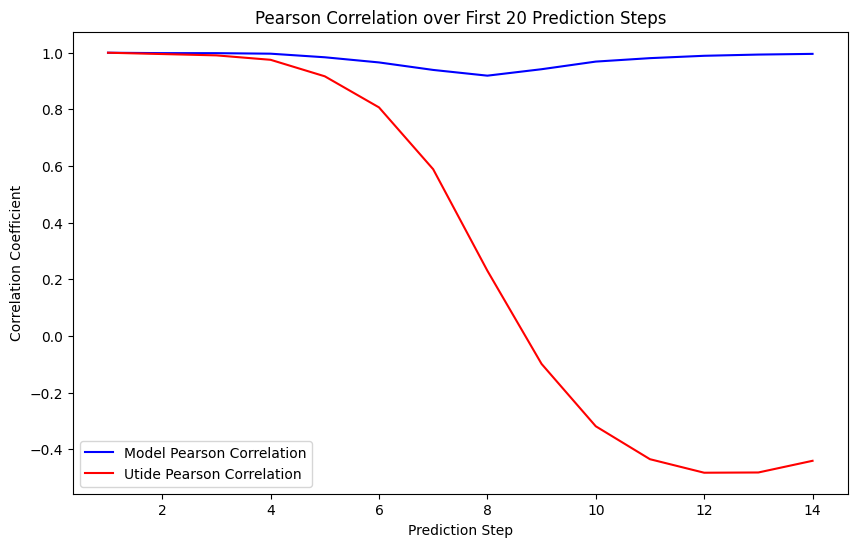

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(pearson_corr_scores[:15], label='Model Pearson Correlation', color='blue')
plt.plot(utide_pearson_corr_scores[:15], label='Utide Pearson Correlation', color='red')
plt.xlabel('Prediction Step')
plt.ylabel('Correlation Coefficient')
plt.title('Pearson Correlation over First 20 Prediction Steps')
plt.legend()
plt.show()

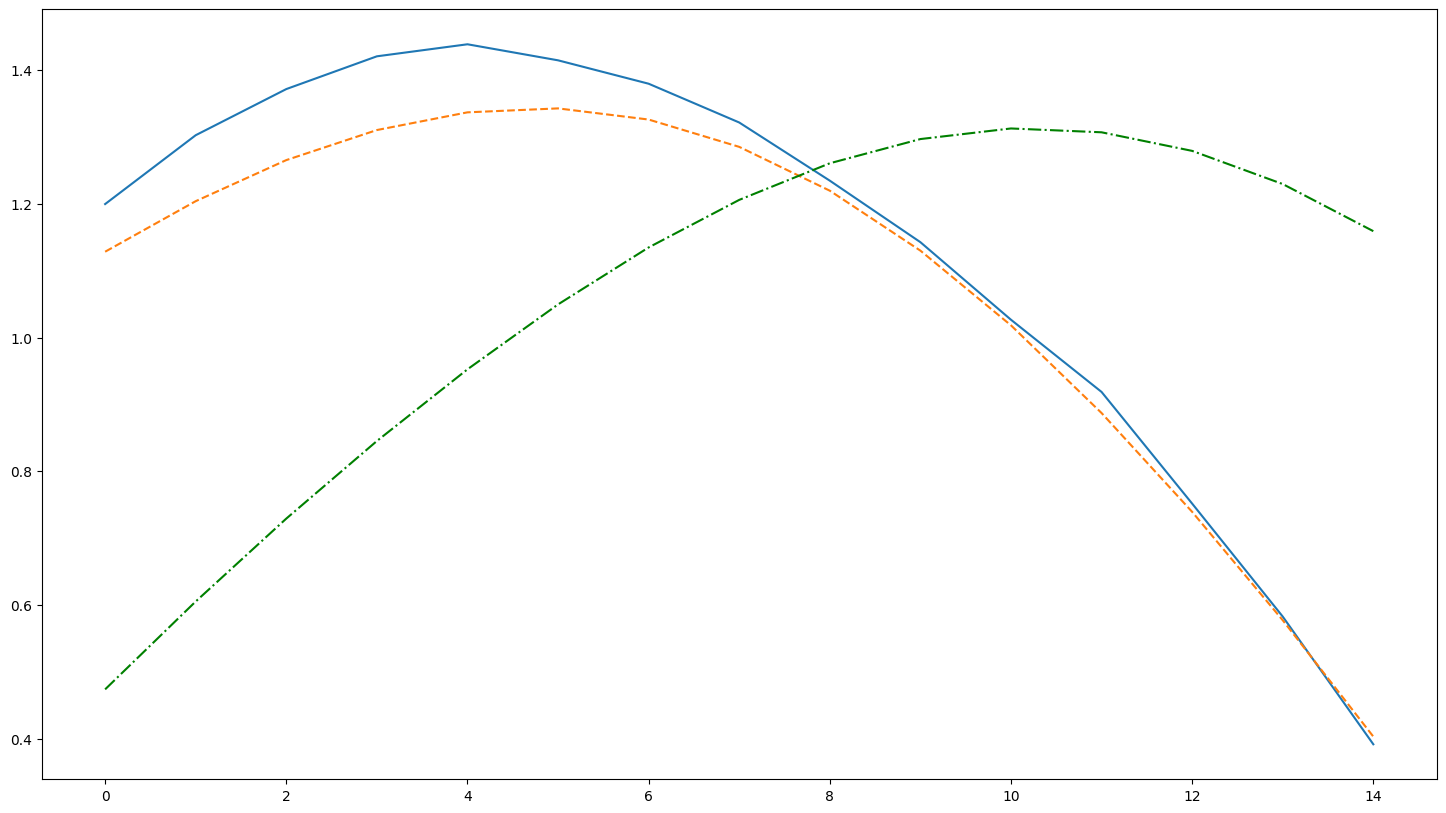

In [ ]:
plt.figure(figsize=(18, 10))
plt.plot(actual_values[:15], label="Actual Values")  # Actual test data
plt.plot(predicted_values[:15], label="Model Predicted Values", linestyle="--")  # Model predictions
plt.plot(utide_predicted_values[:15], label="Utide Values", linestyle="-.", color='green', linewidth=1.5)  # Utide values
